# !pip install tensorflow==1.15
!pip install stable-baselines[mpi]==2.10.2

In [1]:
import time
import pickle
import os
import math
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gym import spaces
from stable_baselines import DQN
from stable_baselines import PPO1
from stable_baselines import PPO2
from stable_baselines import A2C

/home/amirmahdi/anaconda3/envs/RL_Project2/lib/python3.7/site-packages/ale_py/roms/utils.py:90: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for external in metadata.entry_points().get(self.group, []):


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/home/amirmahdi/anaconda3/envs/RL_Project2/lib/python3.7/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


There are 6 possible log levels. Here it is a list of them starting from high verbosity to low:
* 1. Trace : detail info for tracing
* 2. Debug
* 3. Info : important but normal
* 4. Warn
* 5. Error
* 6. Fatal

Among all these 6 log levels, we have decided to eliminate **Error** and **Fatal** as these two are mostly related to runtime behavioir while the information that our model try to make its logging decisions only comes from static source code features. There fore it does not have enough knowledge to decide about logs with Error and Fatal level.


**Action space prespective:**


<img src= "images/action_space_implementations.png" alt="alt text"  />

For the first run of the implementation we will consider all of the for levels (**Combined**), and after this we implement the other way to compare them together.

For the first run implementatoin the **action space** takes **6** discrete values; 
* **"0"**: not_Log
* **"1"**: Trace
* **"2"**: Debug
* **"3"**: Info
* **"4"**: Warn
* **"5"**: IDK*

**Observatio space prespective:**

Observation space is going to be a vector (box) representing each function (rows of our dataset). It has shape of (1,14) it is a vector and we have 14 features to illusterate the fuction under study.

**Reward Function:**

<img src="images/reward_function.drawio.png" />

<img src="images/sigmoid1.png" 
 longdesc="https://www.wolframalpha.com/input?i=plot+%28%28sigmoid+function+0.3x+%29+minus+0.5+%29+multiply+by+2++from+-10+to+10" title="from WolframAlpha"/>

<img src="images/sigmoid2.png" />

The reward will be -4 if it was supposed to be logged but it was not, or vise versa. It will be 1 + sigmoid(features) if the chosen action by the model is the same as "_action_determiner"._ It wil be - abolute difference of determined log action and taken action. 

All these decisions might get changed or modified in testing and when we get to see the results.


**Log Level:**

<img src="images/which-log-level.png" title="from which log level paper"/>

<img src="images/which-log-level1.png" title="from which log level paper"/>

**Logic behind the _action_determiner:**

This function is developed based on one main deenition : " Most important performance bugs ( the ones that are more common to happend and more specific) will have **higher** **verbose**.

Based on this defenition the following performance bugs have been ordered based on their verbosity;( The higher position, the higher verbsity)

* 1. Synchronization
* 2. Race condition and dead Lock
* 3. Nested Loop level
* 4. API

We have came up we this defenition based on two main factors: 1. the importance of the performance bugs based on previous studies and our litreture review (imperical study) 2. Our features are more well defined to capture some of the performance bugs comparing to others, so that we have considered higher performance verbose for those performance bugs.

In [2]:
class source_code_env(gym.Env):
    metadata = {'render.modes': ['console']}
    
    number_of_actions = 6
    
    
    actions = {
        "NOT_LOG": 0,
        "TRACE": 1,
        "DEBUG": 2,
        "INFO": 3,
        "WARN": 4,
        "IDK": 5
    }
    
    features_for_reward_func = {
        "number_of_loops": 0,
        "nesting_level": 1,
        "input_dependant_level": 2,
        "number_of_defined_threads": 3,
        "number_of_started_threads": 4,
        "number_of_join_threads": 5,
        "number_of_defined_locks": 6,
        "number_of_acquired_locks_threads": 7,
        "number_of_released_locks": 8,
        "number_of_usage_of_extra": 9,
        "number_of_usage_of_values_list": 10,
        "number_of_usage_of_select_related": 11
    }
    
    
    def __init__(self, dataset):
        super(source_code_env, self).__init__()
        self.dataset = dataset.copy()
        self.action_space = spaces.Discrete(self.number_of_actions)
        self.observation_space = spaces.Box(low= dataset.min().min(), 
                                            high= dataset.max().max(), 
                                            shape=(len(dataset.columns),))
        self.t = 0
        self.t_limit = len(dataset)
        self.acc_reward = 0
        self.rewards_list = []
        self.acc_rewards_list = []
        
    def _action_determiner(self, obs):
        """
        The implementation logic of assiging each performance bug to a certain log level
        is based on the knowledge from previous studies mentioned above, the how common and important they are and
        also our features capabalities.
        
        arguments:
        
        obs: is supposed to be a vector (a row of the pandas dataframe);
        
        """
        features_for_reward_func = self.features_for_reward_func
        actions = self.actions
        synchronization_features = obs[features_for_reward_func["number_of_defined_threads"]:
            features_for_reward_func["number_of_usage_of_extra"]]
        api_related_features = obs[features_for_reward_func["number_of_usage_of_extra"]:]
        determined_action = actions["IDK"] # Default action
        
        if (obs == 0).all(): # Checking if any of features has occured
            determined_action = actions["NOT_LOG"]
            return determined_action
        elif (synchronization_features > 0).any():
            determined_action = actions["TRACE"]
            
            obs_num_threads = obs[features_for_reward_func["number_of_defined_threads"]]
            obs_num_locks = obs[features_for_reward_func["number_of_defined_locks"]]
            obs_num_join = obs[features_for_reward_func["number_of_join_threads"]]
            race_condition_metric = obs_num_threads - obs_num_locks
            deadlock_metric = obs_num_threads - obs_num_join
            if race_condition_metric > 0 or deadlock_metric > 0: 
                determined_action = actions["DEBUG"]
            return determined_action
        else:
            nested_loop = obs[features_for_reward_func["nesting_level"]] > 0
            input_dependant = obs[features_for_reward_func["input_dependant_level"]] > 0
            if nested_loop or input_dependant:
                determined_action = actions["INFO"]
                return determined_action
            elif (api_related_features != 0).any():
                determined_action = actions["WARN"]
                return determined_action
        return determined_action
        
    
    def _sigmoid(self, x_coefficient, x):
        
        """
        arguments:
        
        x_coefficient: this is to control the slope of the Sigmoid function.
        x: input of the Sigmoid function.
        """
            
        x = x_coefficient * x
        return ((1/(1 + np.exp(-x))) - 0.5) * 2
    
    def _reward(self, obs, taken_action):
        
        """
        arguments:
        
        obs: is supposed to be a vector (a row of the pandas dataframe);
        taken action: is the action taken by model based on obs. Its value could be {0, 1 ... 4}.
        """
        """
        action_based_on_obs = None
        
        if(obs.sum() == 0):
            action_based_on_obs = actions("NOT_LOG")
        else:
            action_based_on_obs = actions("TRACE")"""
        
        determined_action = self._action_determiner(obs)
        
        if taken_action == determined_action: # if the answer is correct
            reward = 1 + self._sigmoid(0.3, np.sum(obs))
            return reward
        elif determined_action == 0 and taken_action != 0: # if it was not supposed to be logged but it logged
            reward = -4 #Worse scenario 0 - 4
            return reward
        elif determined_action != 0 and taken_action == 0: # if it was supposed to be logged but it did not log
            reward = -4 #Worse scenario 0 - 4
            return reward
        else: # wrong log level
            reward = -abs(taken_action - determined_action) # will be -3 at the worse
            return reward
        
    
    def reset(self):
        self.t = 0
        obs = self.dataset.iloc[self.t].astype(np.float32)
        return np.array(obs)
    
    def step(self, action):
        
        done = False
        
        obs = self.dataset.iloc[self.t].astype(np.float32) # getting current observation to compute reward
        reward = self._reward(obs, action)
        self.rewards_list.append(reward)
        self.acc_reward = self.acc_reward + reward
        self.acc_rewards_list.append(self.acc_reward)
        self.t += 1
        if self.t >= self.t_limit:
            done = True
            #obs = self.dataset.iloc[0].astype(np.float32) # getting updated observation after taken action
            obs = self.reset() # getting updated observation after taken action
        else:
            obs = self.dataset.iloc[self.t].astype(np.float32) # getting updated observation after taken action
        
        info={}
        
        return np.array(obs), reward, done, info
    
    def acc_zero(self):
        self.acc_reward = 0
        self.acc_rewards_list = []
        self.rewards_list = []

In [3]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')

# Evaluation

### [1] Test

In [6]:
dataset = pd.read_csv("/home/amirmahdi/projects/Adaptive-Logging-system-git/code/data/dataframe_main.csv")
dataset = dataset.set_index("ID")
dataset = dataset.astype(int)

In [51]:
# Check the environment:
from stable_baselines.common.env_checker import check_env
env = source_code_env(dataset)
# If the environment don't follow the interface,        an error will be thrown
check_env(env, warn=True)

### [2] Main

In [4]:
dataset = pd.read_csv("/home/amirmahdi/projects/Adaptive-Logging-system-git/code/data/dataframe_testing.csv")
dataset = dataset.set_index("ID")
dataset = dataset.astype(int)

In [5]:
dataset

,number_of_loops,loop_input_dependent_level,nested_loop_level,number_of_defined_threads,number_of_started_threads,number_of_join_threads,number_of_defined_locks,number_of_acquired_locks_threads,number_of_released_locks,number_of_usage_of_extra,number_of_usage_of_values_list,number_of_usage_of_select_related
ID,,,,,,,,,,,,
5a723cc4bc73898ea681993d1ae70ba4a7a8aaa9,0,0,0,0,0,0,0,0,0,0,0,0
a33b567ba3afcfb275d43fca24a400c8bbd9ae8c,0,0,0,0,0,0,0,0,0,0,0,0
c1884969b3d1bcf7fd5dbf887f5d30c895a35a4d,0,0,0,0,0,0,0,0,0,0,0,0
7bcbe91ed1444729a2dc31f54682468aa79ed0b9,0,0,0,0,0,0,0,0,0,0,0,0
b33c59ca8af612089a8088c4f7737b5cf07d9d22,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4b630cc95a68cab6bd8b46580ce1c20ab3fe2f07,2,1,2,0,0,0,0,0,0,0,0,0
e7bb30d79989988fc73c53b75a4008bbb529c234,0,0,0,0,0,1,0,0,0,0,0,0
87b1cedef9ceb214027ea1159ff423362fdf9516,0,0,0,0,0,1,0,0,0,0,0,0


In [6]:
env = source_code_env(dataset)
DQN_model = DQN('MlpPolicy', env, verbose=0)
A2C_model = A2C('MlpPolicy', env, verbose=0)
PPO1_model = PPO1('MlpPolicy', env, verbose=0)
PPO2_model = PPO2('MlpPolicy', env, verbose=0)







Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where









Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





### DQN:

In [38]:
env.acc_zero()
start_time = time.time()
DQN_model.learn(total_timesteps= 112000)
end_time = time.time()
DQN_model.save("DQN_model")
#del DQN_model
# Save the list to a file
"""with open('DQN_rewards_list.pkl', 'wb') as file:
    pickle.dump(env.rewards_list, file)"""
print("DQN Execution Time: ", end_time - start_time)


DQN Execution Time:  501.7294454574585


In [7]:
DQN_model = DQN.load("DQN_model.zip")

In [31]:
# Load the list from the file
with open('DQN_rewards_list.pkl', 'rb') as file:
    DQN_rewards_list = pickle.load(file)

print(len(DQN_rewards_list))  # Output: [1, 2, 3, 4, 5]

460000


In [21]:
"""batch_size = 100
averages_list = []
for i in range(0, len(env.rewards_list), batch_size):
    # Extract a batch of numbers
    batch = env.rewards_list[i:i + batch_size]
    
    # Calculate the average of the batch and append it to the averages_list
    average = sum(batch) / len(batch)
    averages_list.append(average)"""
batch_size = 40
DQN_y = []
#DQN_rewards_list = env.rewards_list
for i in range(0, len(DQN_rewards_list), batch_size):
    # Extract a batch of numbers
    batch = DQN_rewards_list[i]
    
    DQN_y.append(batch)

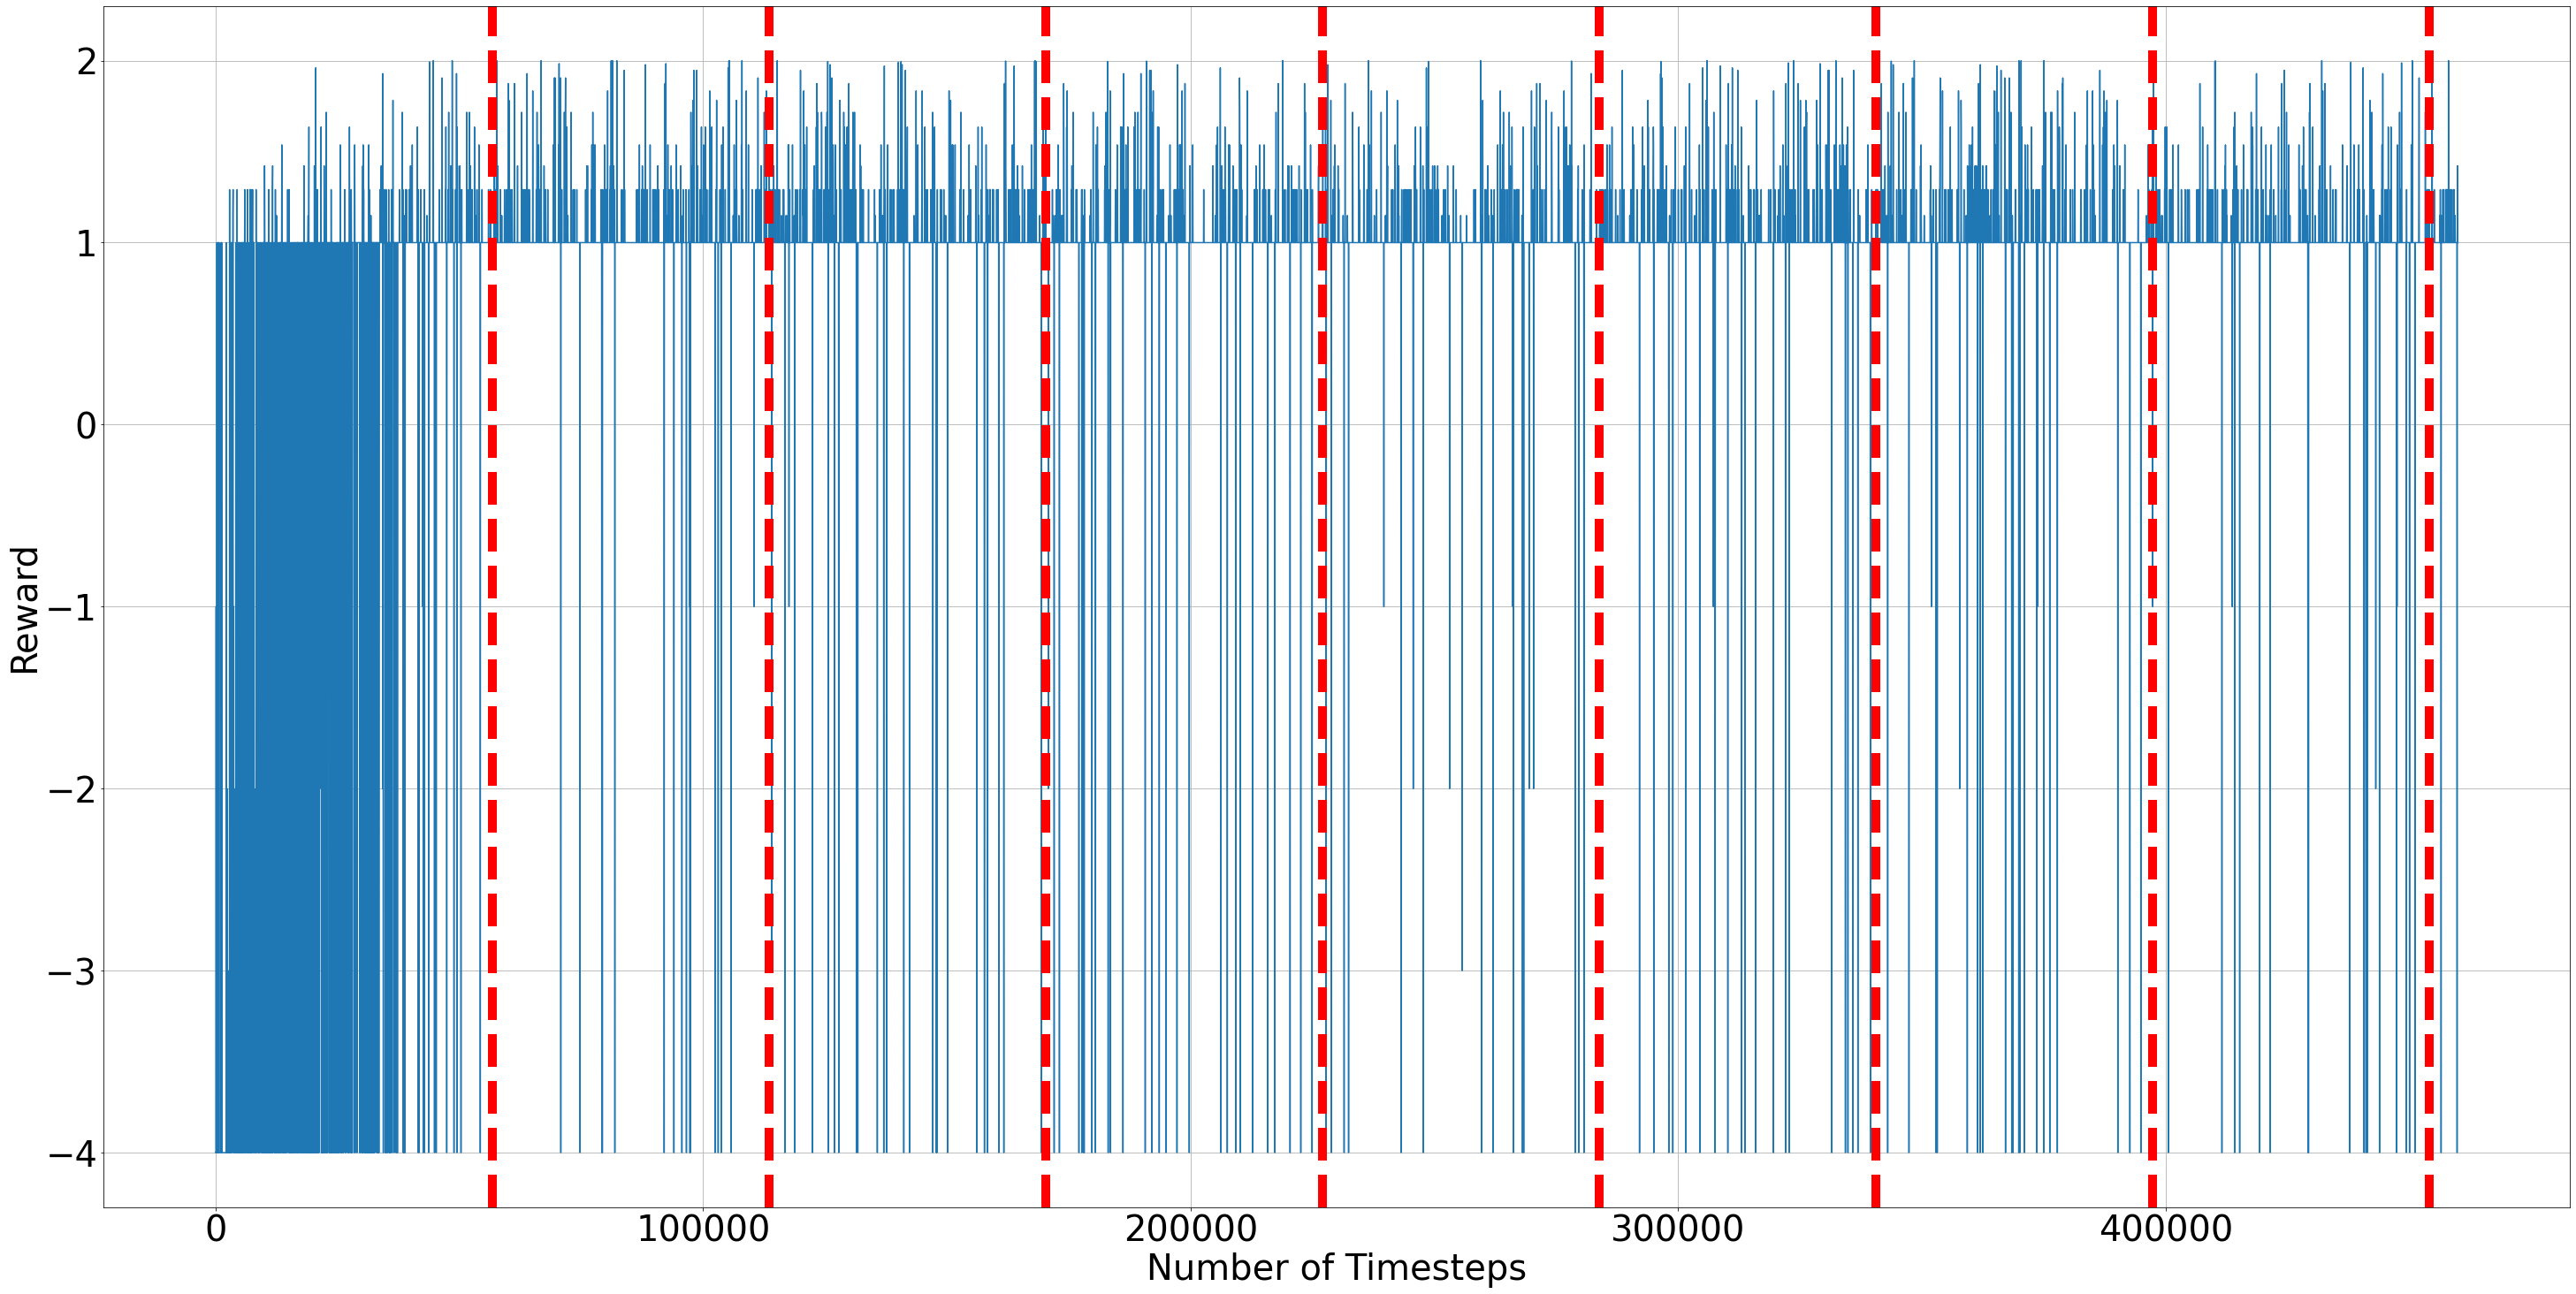

In [22]:
fig = plt.figure( figsize=(50, 25))
i = 0
x = [i*batch_size for i in range(0, len(DQN_y))]
y = DQN_y
plt.plot(x, y)
plt.xlabel('Number of Timesteps', fontsize=40)
plt.ylabel('Reward', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.title("DQN Learning Curve")

counter = 56755
while(counter<460000):
    plt.axvline(x=counter, color='red', linestyle='--', label='Episode', linewidth=10)
    counter = counter + 56755


plt.grid(True)
plt.savefig("DQN.pdf")
plt.show()


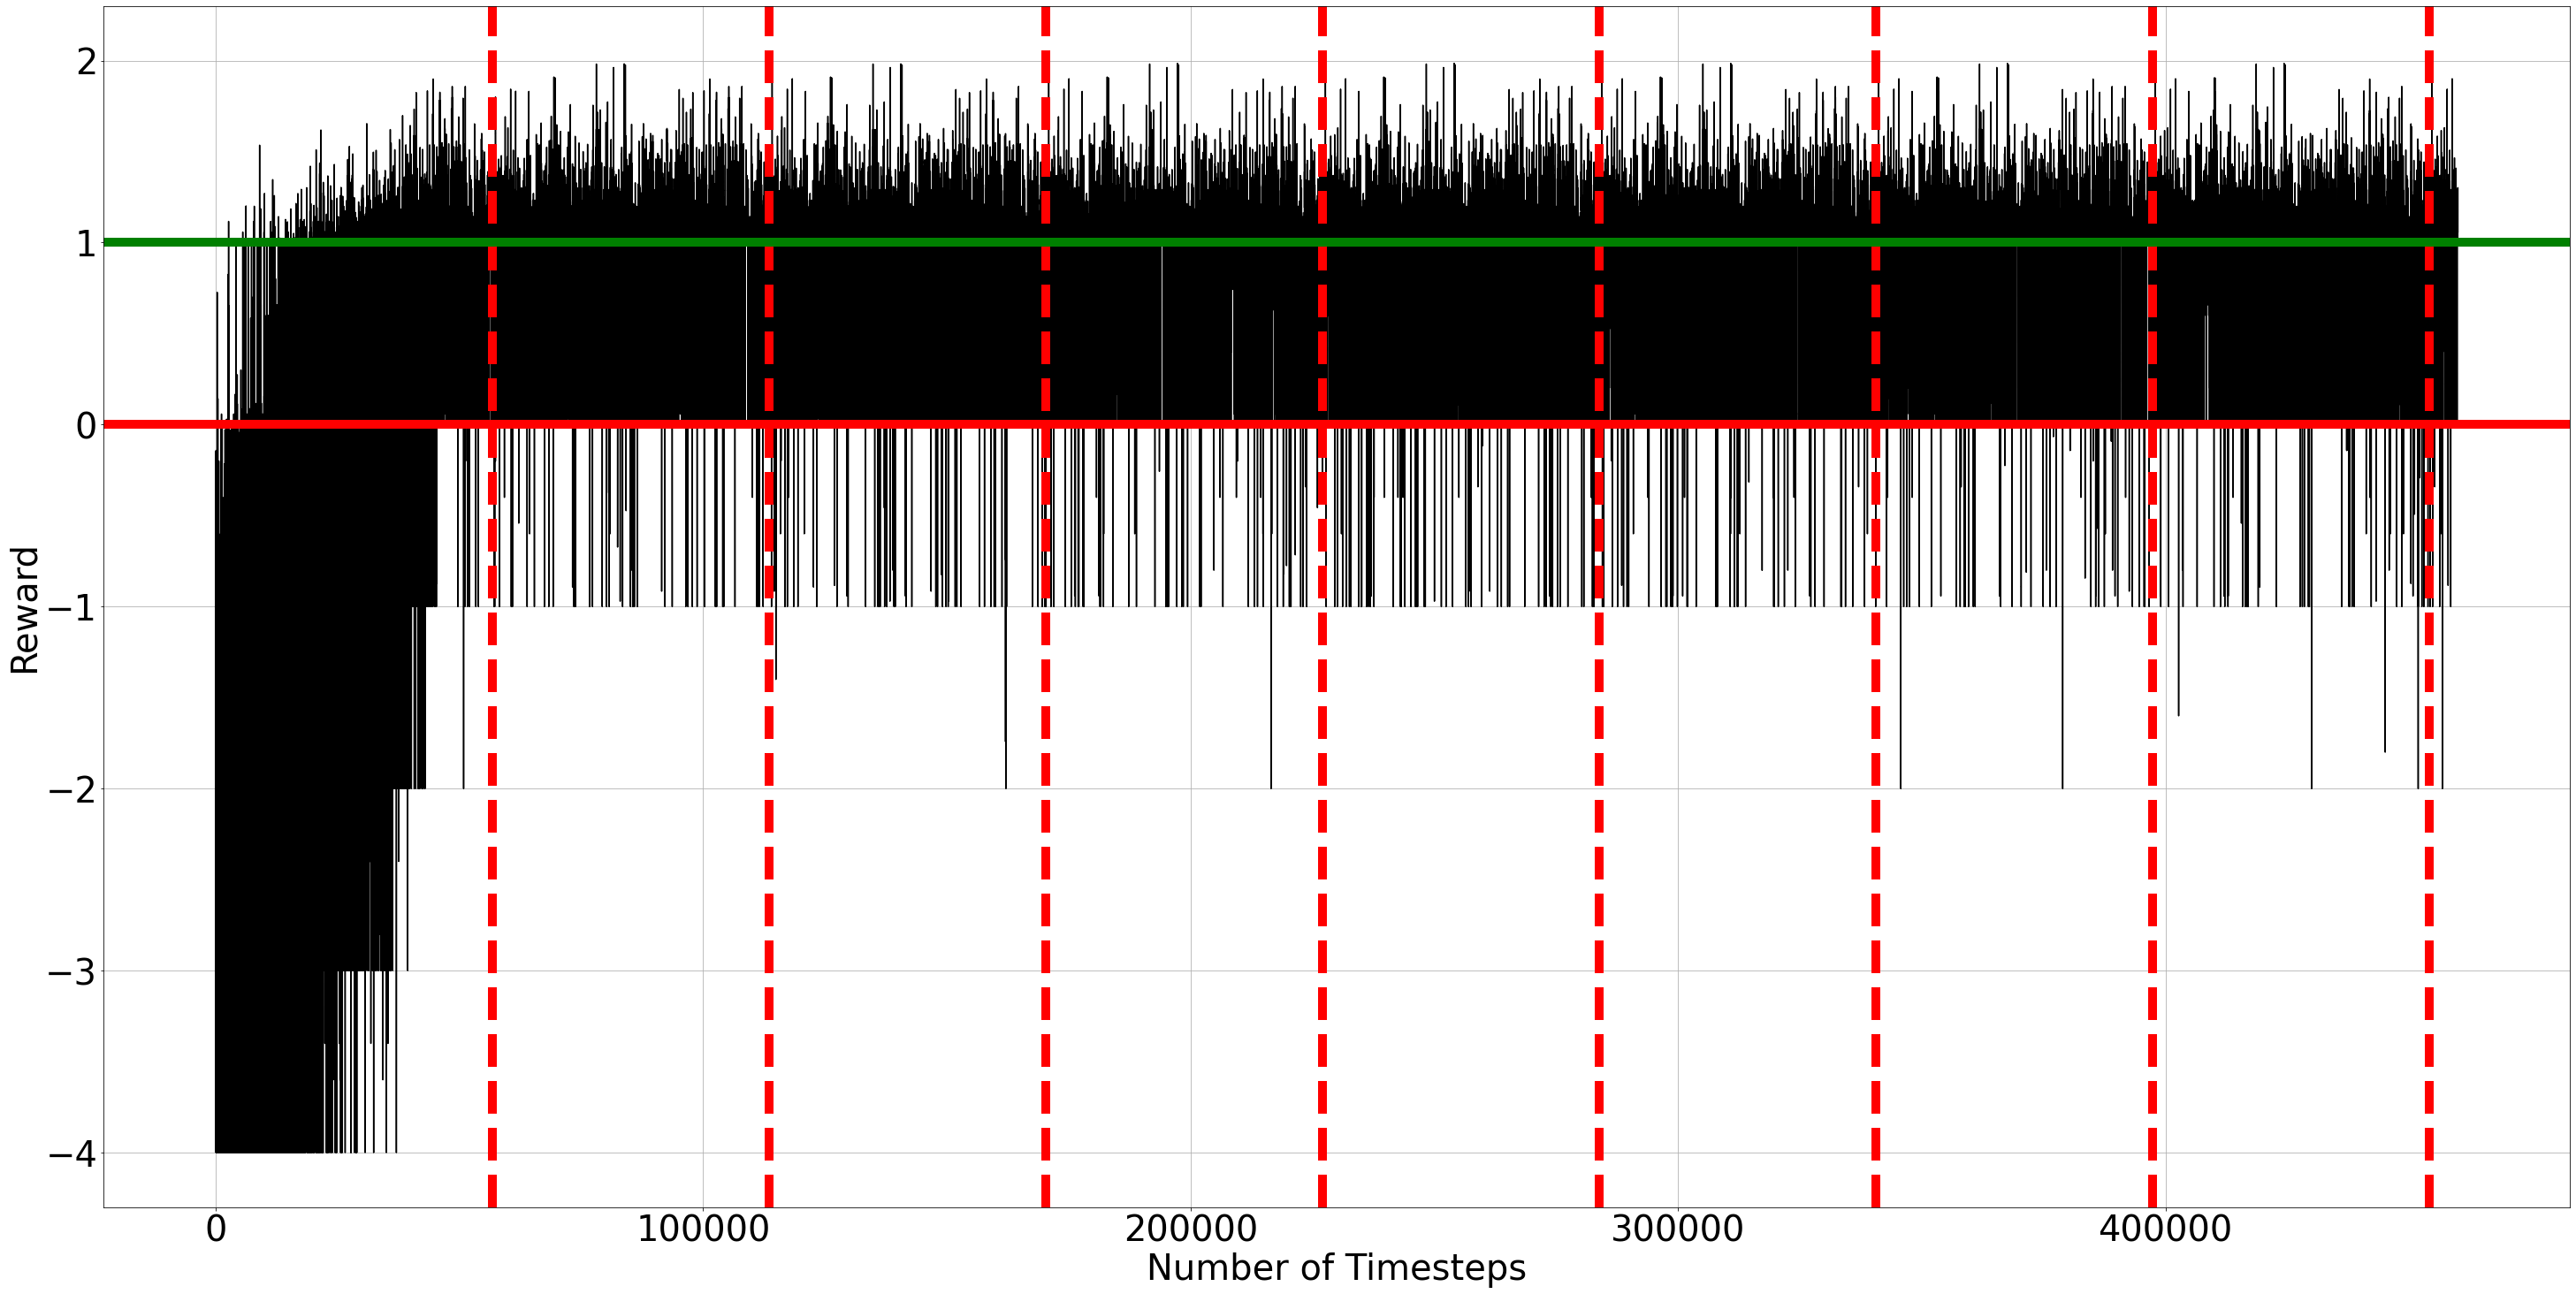

In [32]:

fig = plt.figure( figsize=(50, 25))
y = moving_average(DQN_rewards_list, 5)
x = [i for i in range(0, len(y))]
plt.plot(x, y, color="black")
plt.xlabel('Number of Timesteps', fontsize=40)
plt.ylabel('Reward', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.title("DQN Learning Curve")

counter = 56755
while(counter<460000):
    plt.axvline(x=counter, color='red', linestyle='--', label='Episode', linewidth=10)
    counter = counter + 56755

plt.axhline(y=1, color='green', linestyle='-', label='Episode', linewidth=10)
plt.axhline(y=0, color='red', linestyle='-', label='Episode', linewidth=10)
plt.grid(True)
plt.savefig("DQN_moving_average.pdf")
plt.show()

### A2C:

In [53]:
env.acc_zero()
start_time = time.time()
A2C_model.learn(total_timesteps= 460000)
end_time = time.time()
A2C_model.save("A2C_model")
#del DQN_model
# Save the list to a file
"""with open('A2C_rewards_list.pkl', 'wb') as file:
    pickle.dump(env.rewards_list, file)"""
print("A2C Execution Time: ", end_time - start_time)

A2C Execution Time:  1201.475760936737


In [8]:
A2C_model = A2C.load("A2C_model.zip")

In [14]:
# Load the list from the file
with open('A2C_rewards_list.pkl', 'rb') as file:
    A2C_rewards_list = pickle.load(file)

print(len(A2C_rewards_list))  # Output: [1, 2, 3, 4, 5]

460000


In [44]:
"""batch_size = 100
averages_list = []
for i in range(0, len(env.rewards_list), batch_size):
    # Extract a batch of numbers
    batch = env.rewards_list[i:i + batch_size]
    
    # Calculate the average of the batch and append it to the averages_list
    average = sum(batch) / len(batch)
    averages_list.append(average)"""
batch_size = 5
A2C_y = []
#A2C_rewards_list = env.rewards_list
for i in range(0, len(A2C_rewards_list), batch_size):
    # Extract a batch of numbers
    batch = A2C_rewards_list[i]
    
    A2C_y.append(batch)

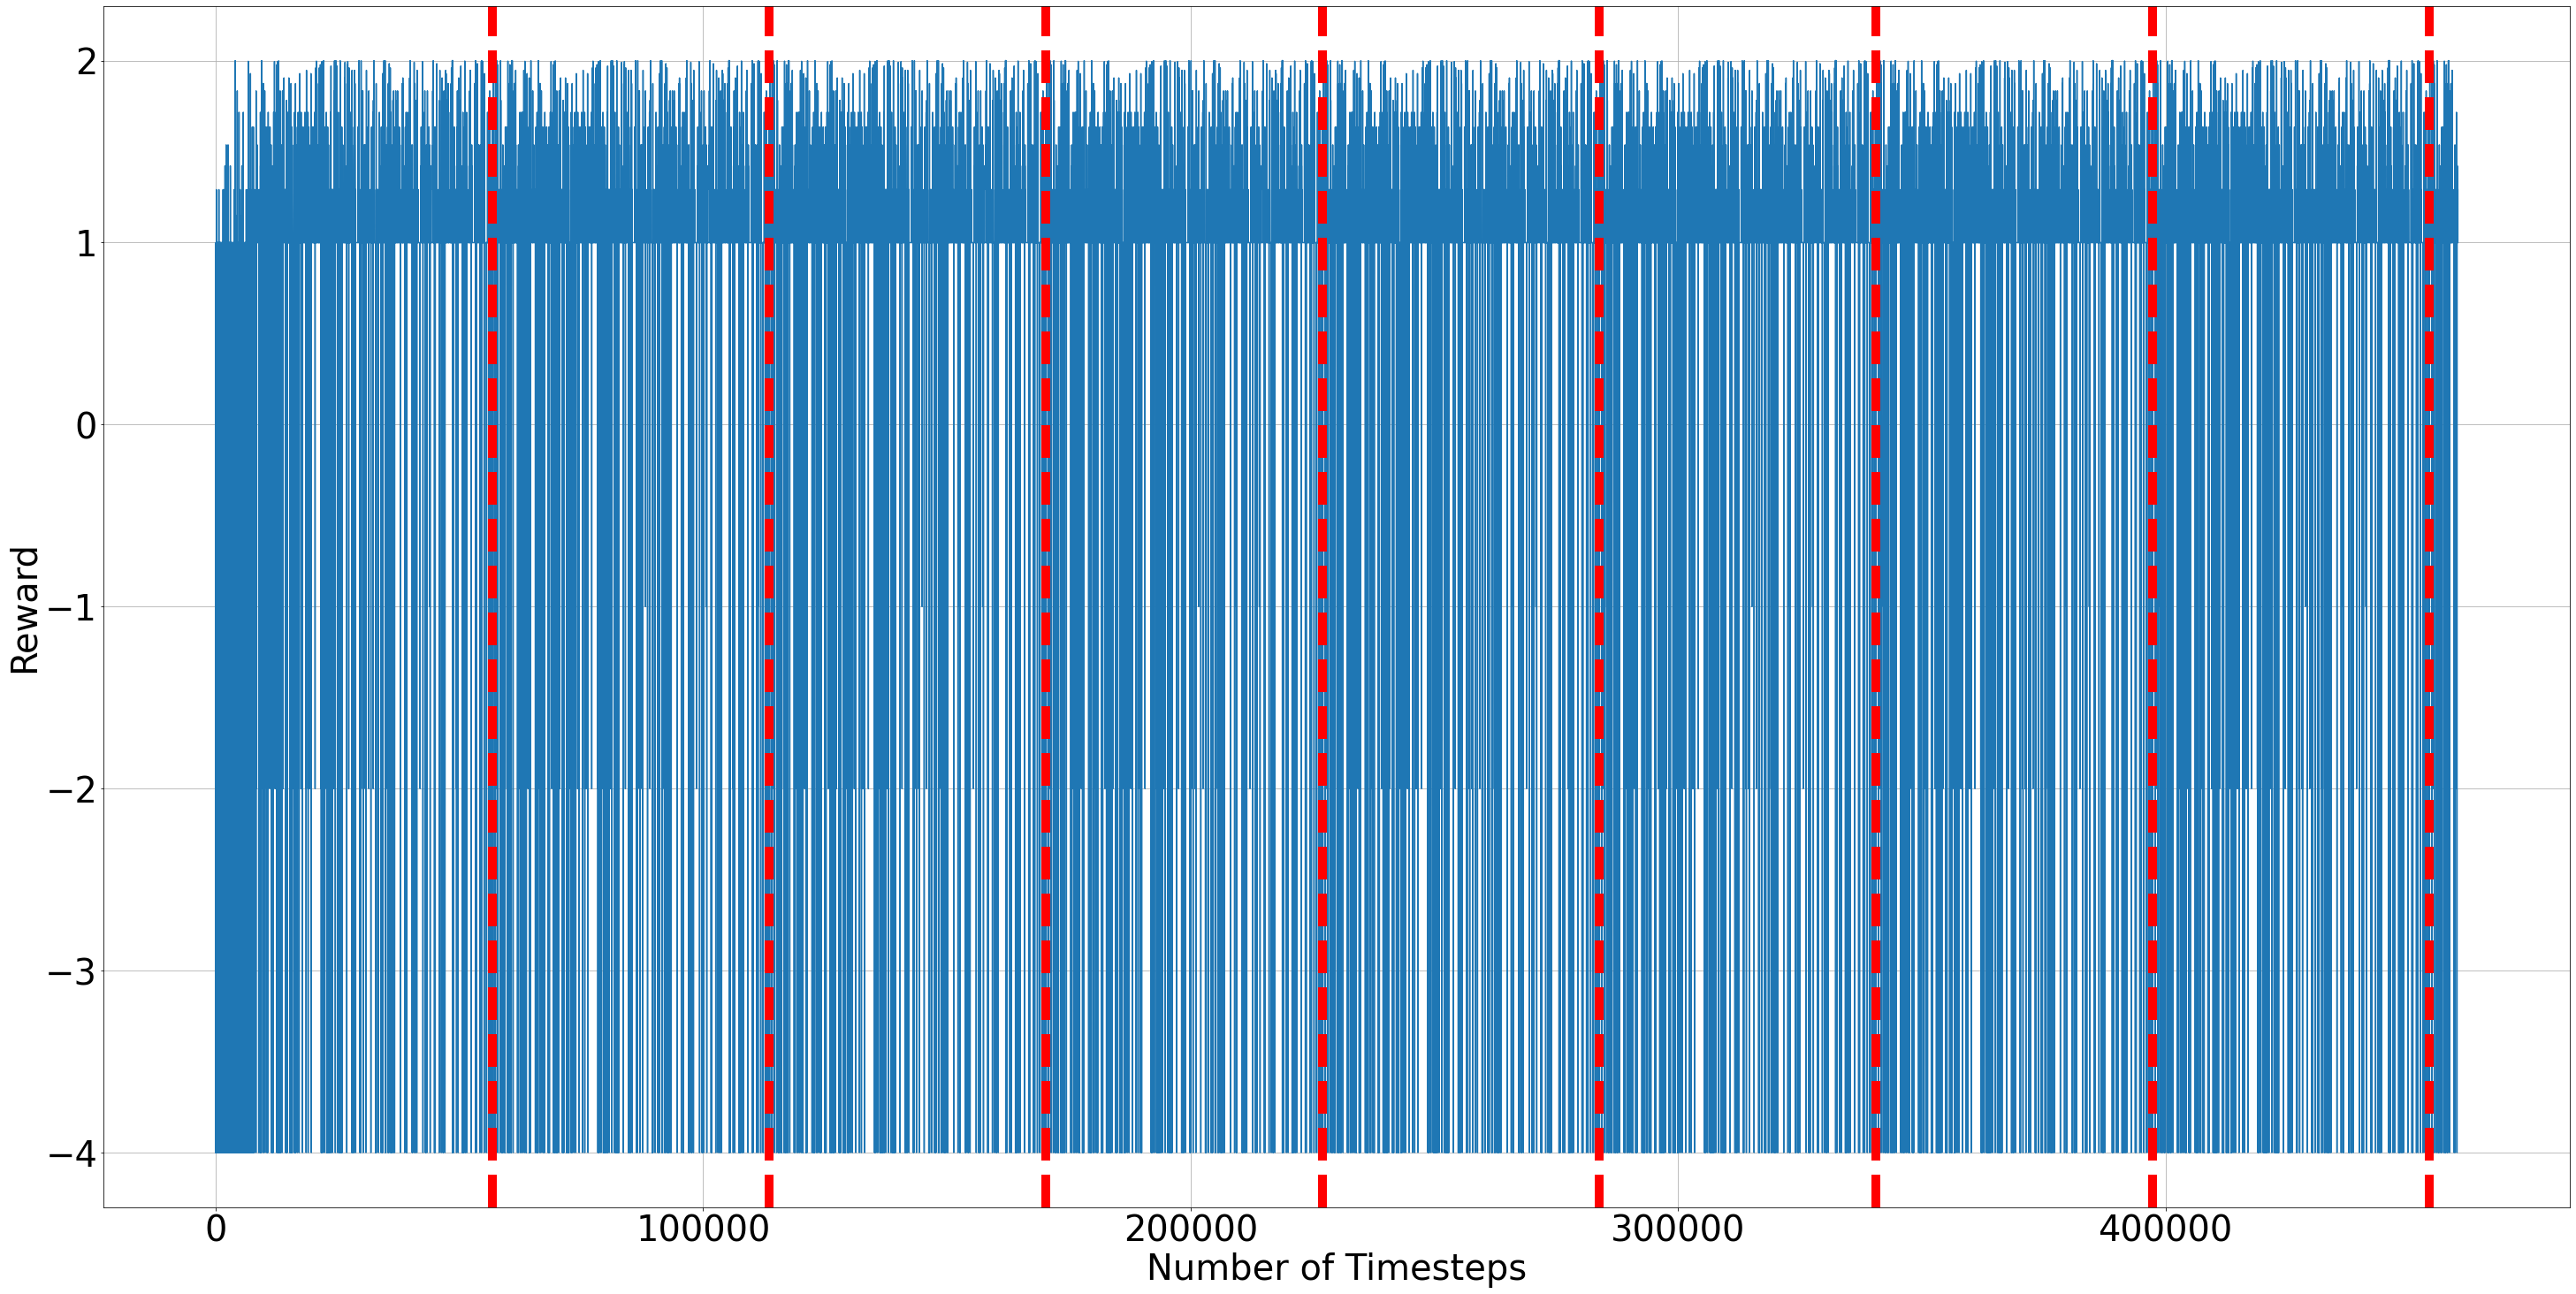

In [45]:
fig = plt.figure( figsize=(50, 25))
i = 0
x = [i*batch_size for i in range(0, len(A2C_y))]
y = A2C_y
plt.plot(x, y)
plt.xlabel('Number of Timesteps', fontsize=40)
plt.ylabel('Reward', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.title("DQN Learning Curve")

counter = 56755
while(counter<460000):
    plt.axvline(x=counter, color='red', linestyle='--', label='Episode', linewidth=10)
    counter = counter + 56755


plt.grid(True)
#plt.savefig("A2C.pdf")
plt.show()


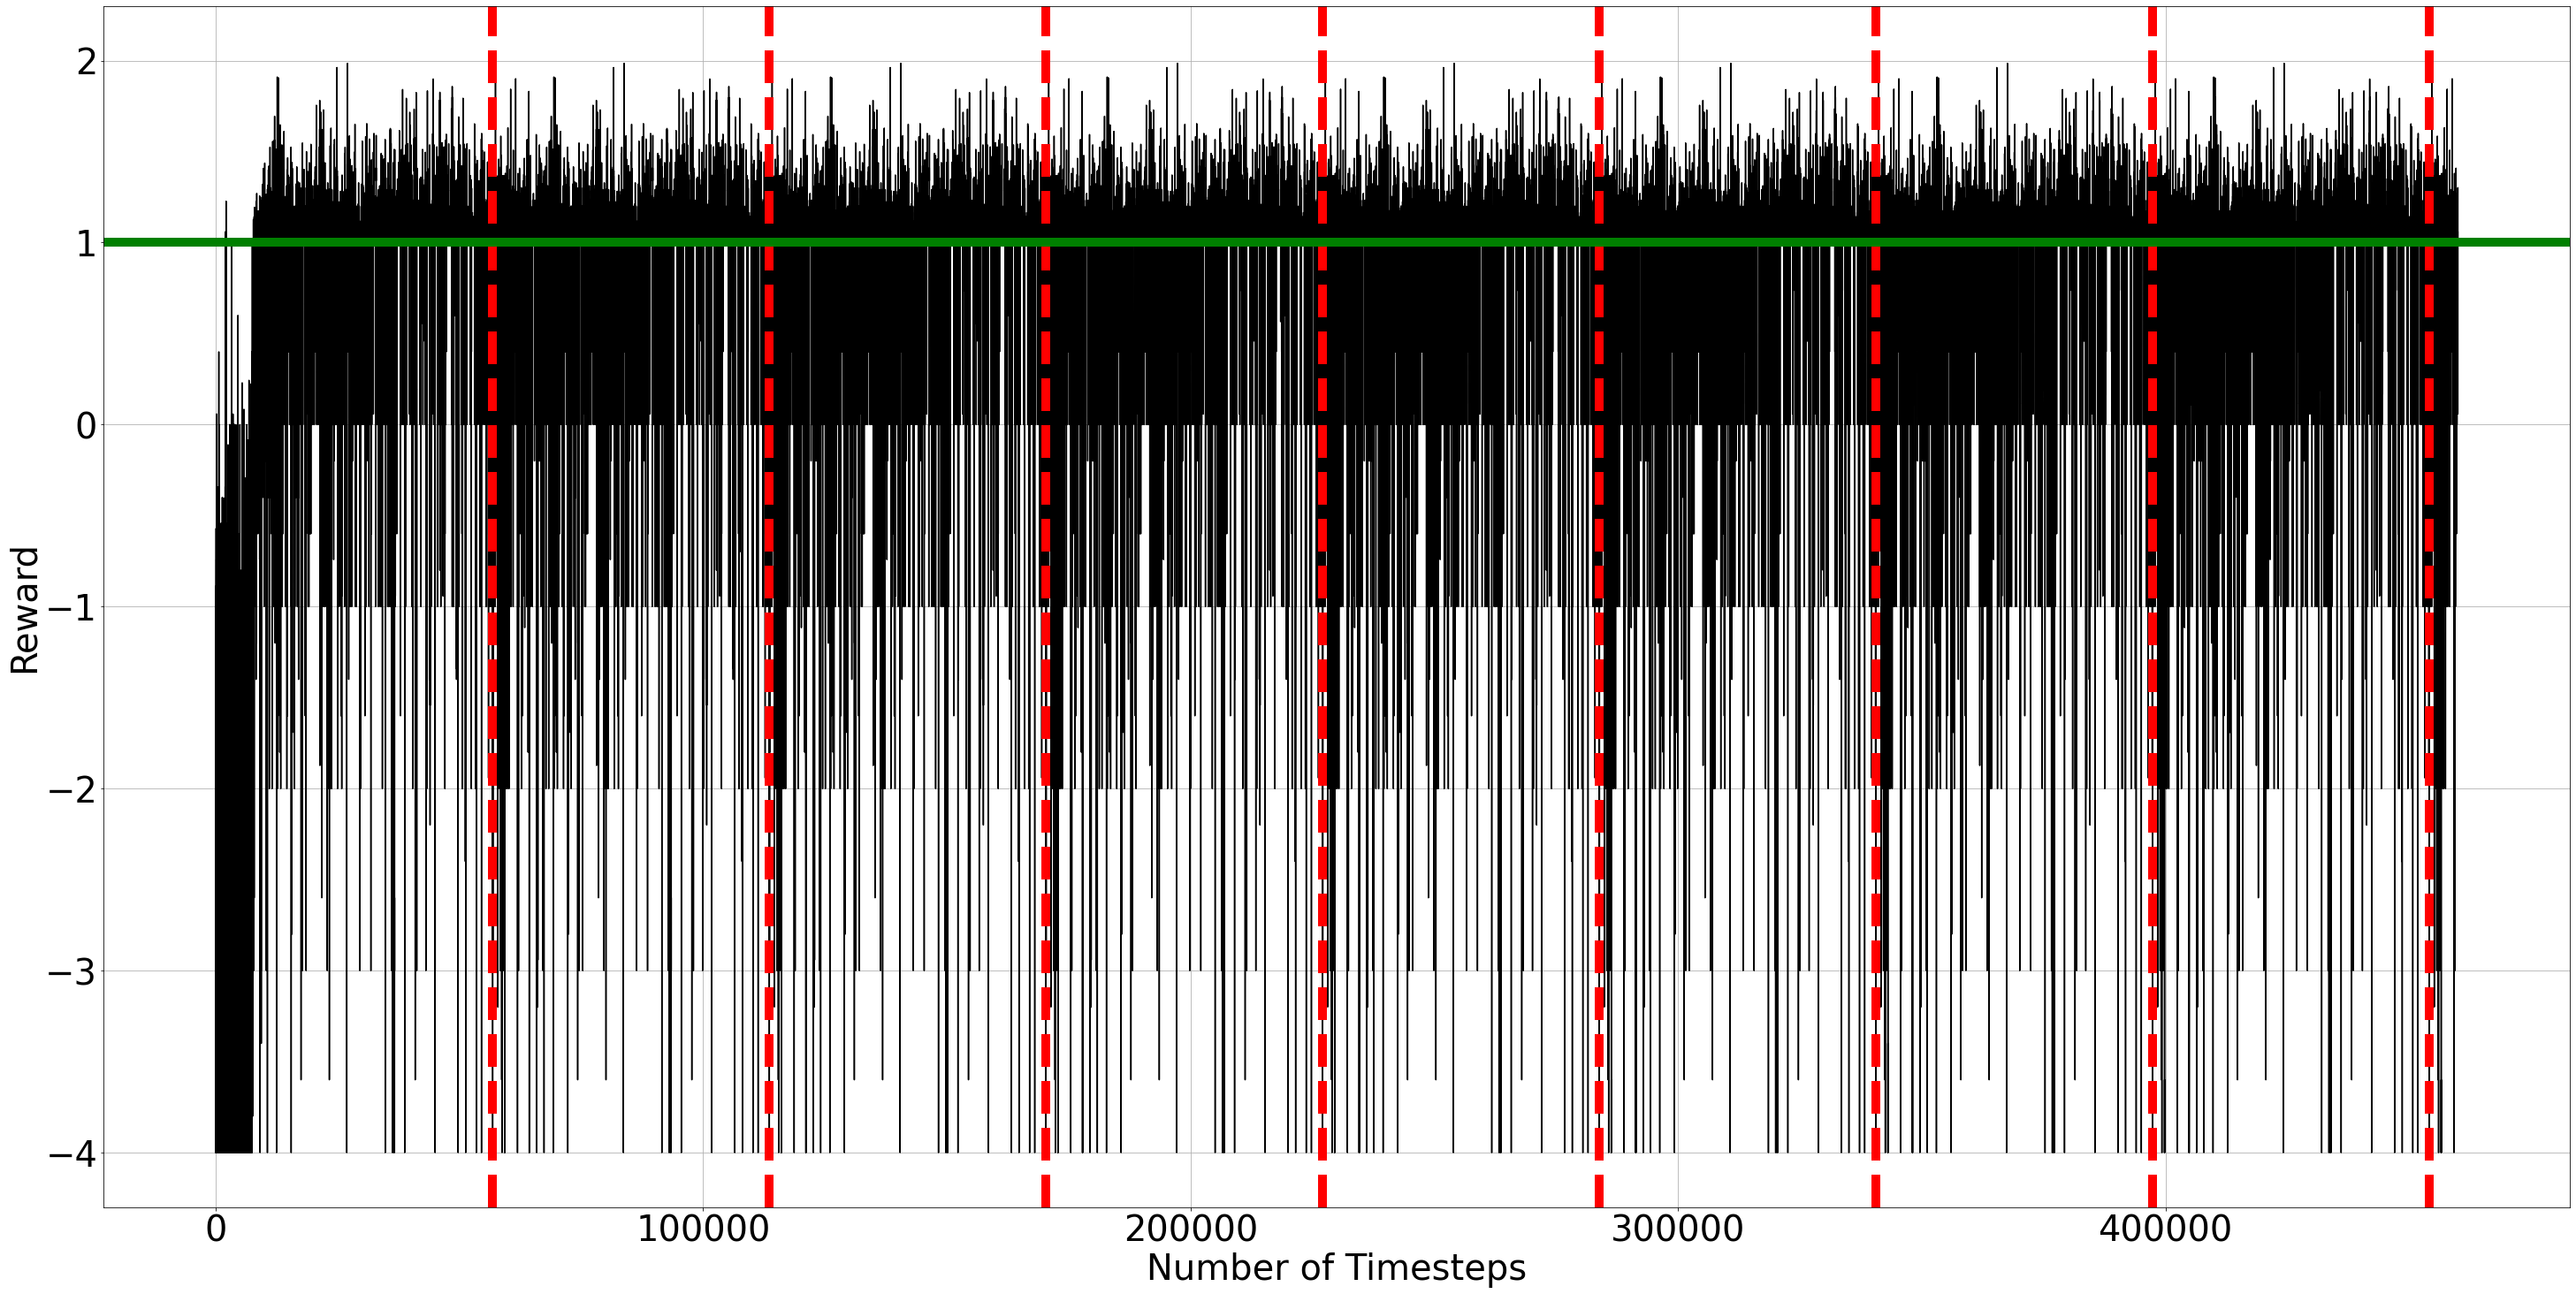

In [53]:
fig = plt.figure( figsize=(50, 25))
y = moving_average(A2C_rewards_list, 5)
x = [i for i in range(0, len(y))]
plt.plot(x, y, color="black")
plt.xlabel('Number of Timesteps', fontsize=40)
plt.ylabel('Reward', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.title("DQN Learning Curve")

counter = 56755
while(counter<460000):
    plt.axvline(x=counter, color='red', linestyle='--', label='Episode', linewidth=10)
    counter = counter + 56755

plt.axhline(y=1, color='green', linestyle='-', label='Episode', linewidth=10)
#plt.axhline(y=0, color='red', linestyle='-', label='Episode', linewidth=10)
plt.grid(True)
plt.savefig("A2C_moving_average.pdf")
plt.show()

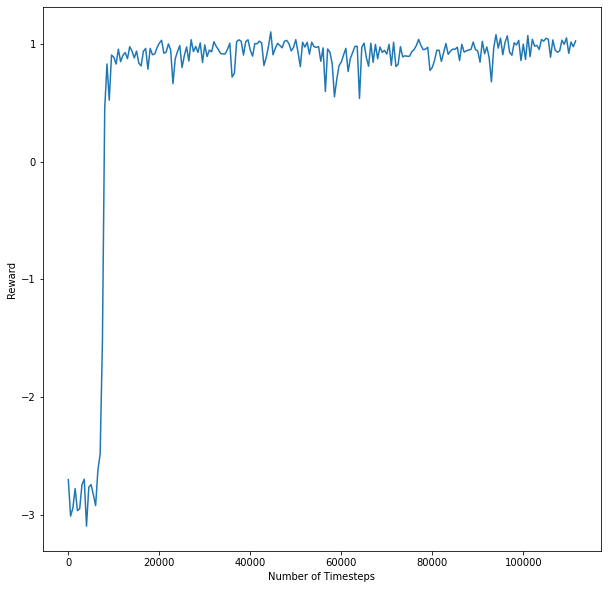

In [38]:
fig = plt.figure( figsize=(10, 10))
i = 0
x = [i*batch_size for i in range(0, len(averages_list))]
y = averages_list
plt.plot(x, y)
plt.xlabel('Number of Timesteps')
plt.ylabel('Reward')
#plt.title("Learning Curve")
plt.show()
#plt.savefig("fisrt step.pdf")

### PPO1

In [18]:
env.acc_zero()
start_time = time.time()
PPO1_model.learn(total_timesteps= 460000)
end_time = time.time()
PPO1_model.save("PPO1_model")
#del DQN_model
# Save the list to a file
with open('PPO1_rewards_list.pkl', 'wb') as file:
    pickle.dump(env.rewards_list, file)
print("PPO1 Execution Time: ", end_time - start_time)

PPO1 Execution Time:  1000.856094121933


In [9]:
PPO1_model = PPO1.load("PPO1_model.zip")

In [24]:
# Load the list from the file
with open('PPO1_rewards_list.pkl', 'rb') as file:
    PPO1_rewards_list = pickle.load(file)

print(len(PPO1_rewards_list))  # Output: [1, 2, 3, 4, 5]

460032


In [42]:
"""batch_size = 100
averages_list = []
for i in range(0, len(env.rewards_list), batch_size):
    # Extract a batch of numbers
    batch = env.rewards_list[i:i + batch_size]
    
    # Calculate the average of the batch and append it to the averages_list
    average = sum(batch) / len(batch)
    averages_list.append(average)"""
batch_size = 5
PPO1_y = []
#DQN_rewards_list = env.rewards_list
for i in range(0, len(PPO1_rewards_list), batch_size):
    # Extract a batch of numbers
    batch = PPO1_rewards_list[i]
    
    PPO1_y.append(batch)

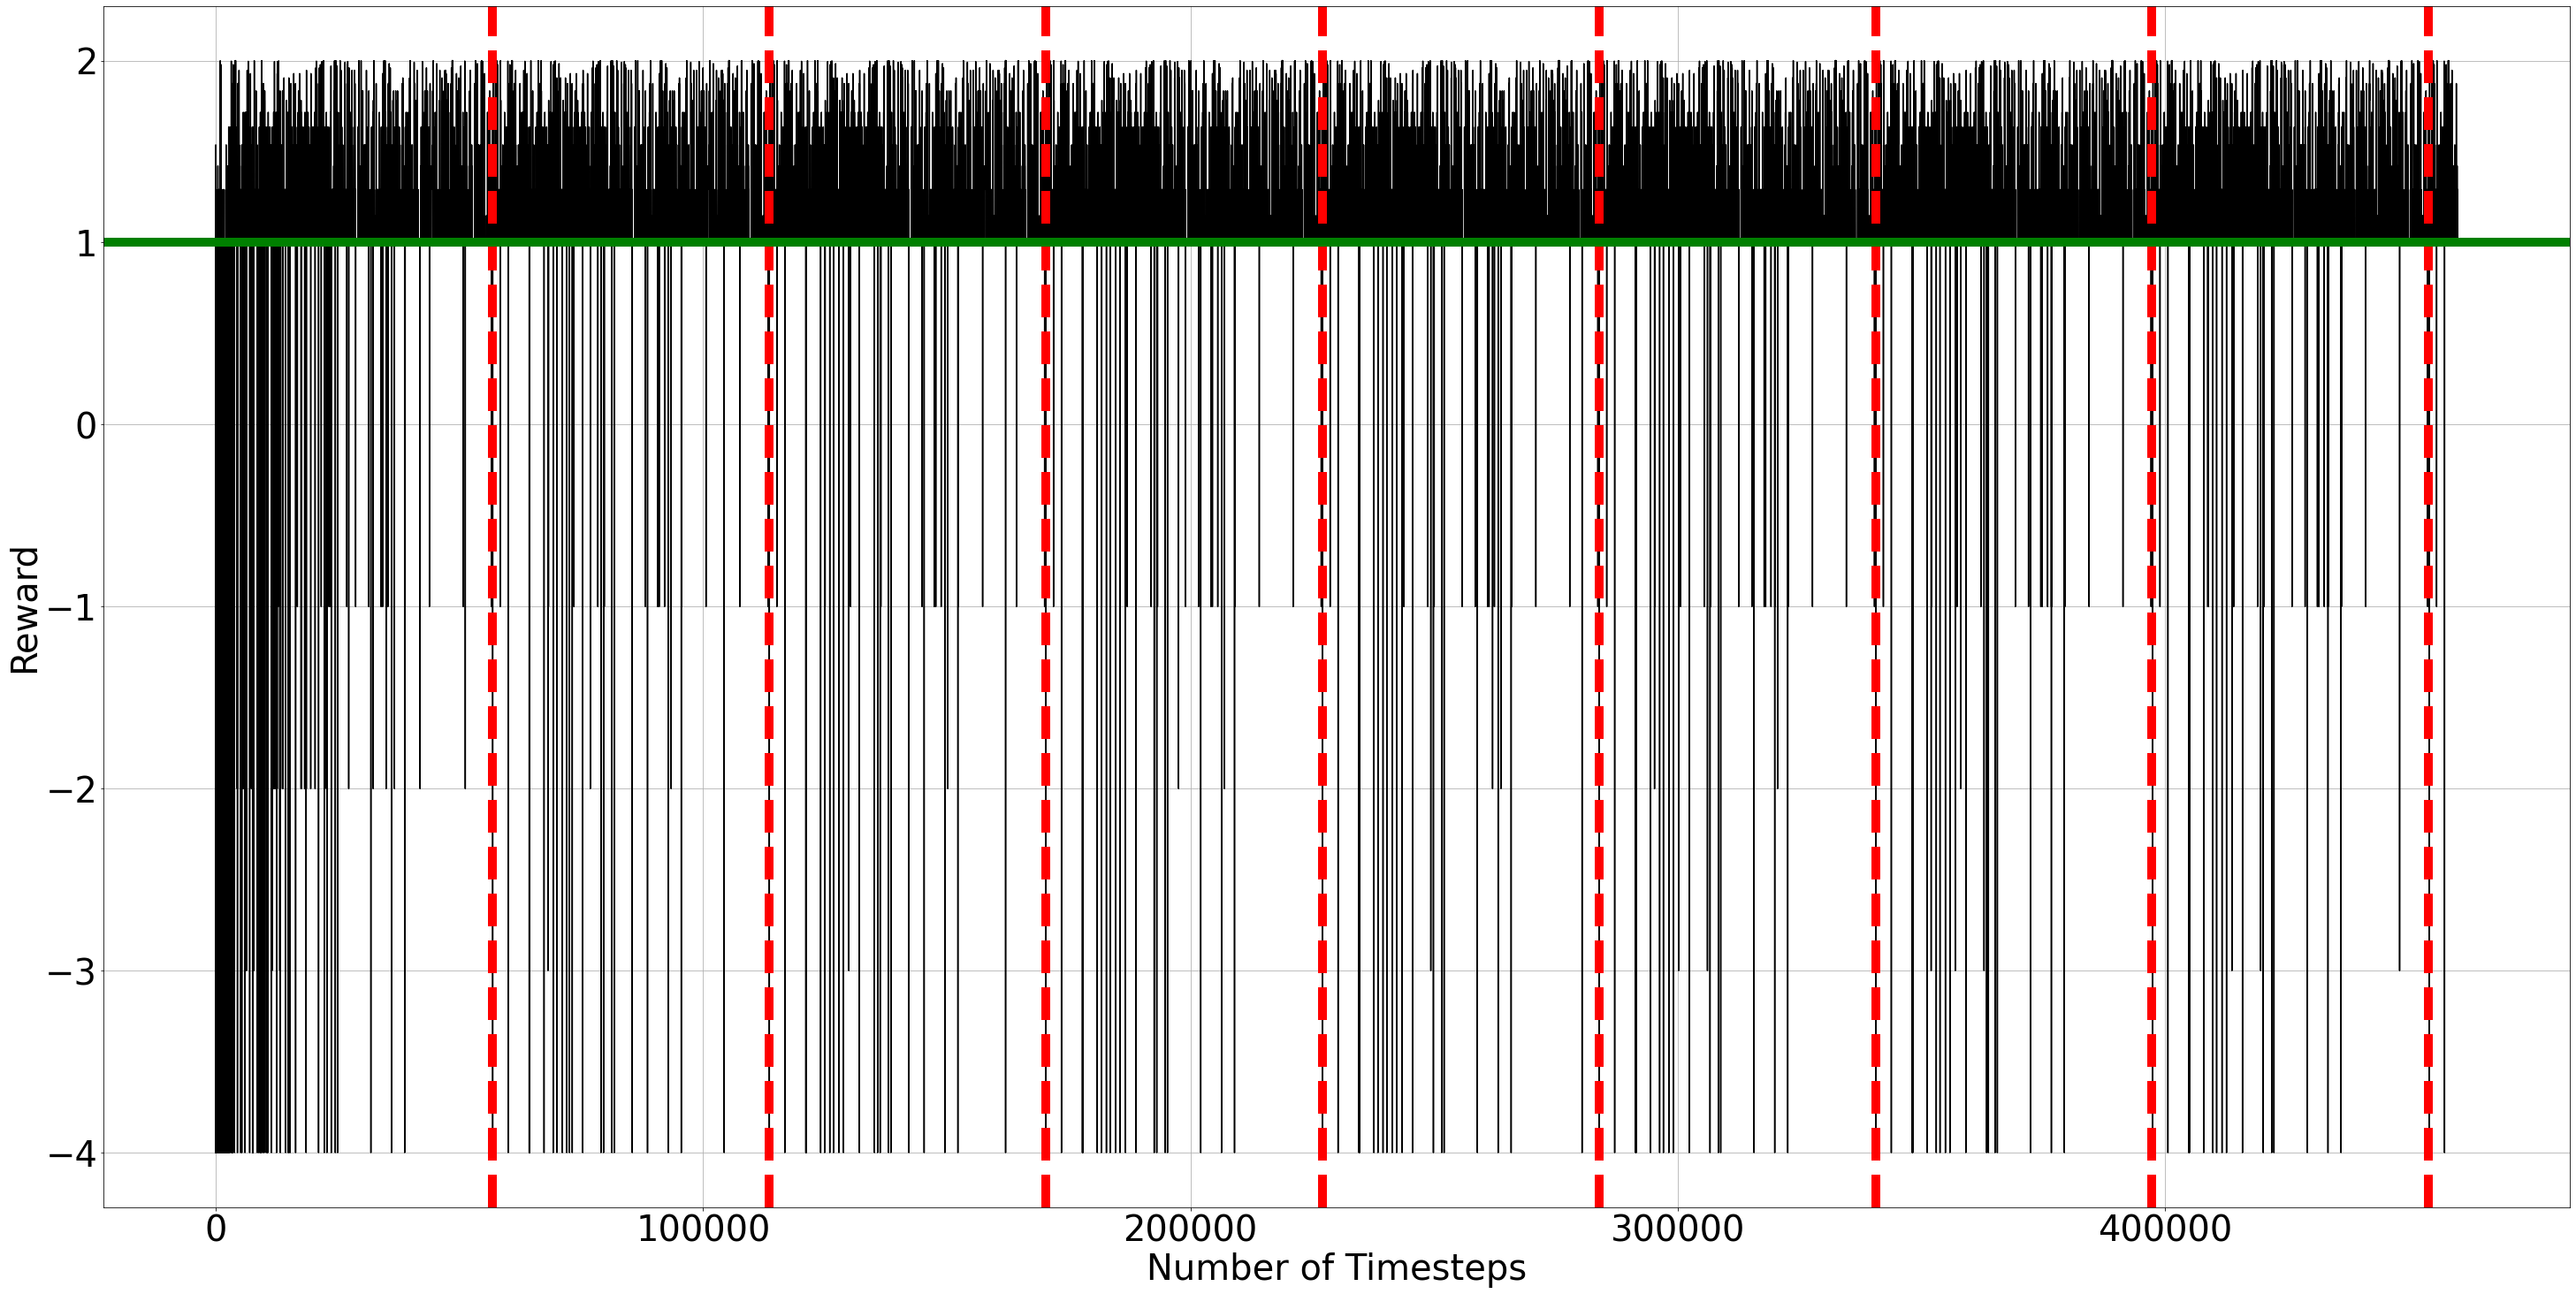

In [55]:
fig = plt.figure( figsize=(50, 25))
i = 0
x = [i*batch_size for i in range(0, len(PPO1_y))]
y = PPO1_y
plt.plot(x, y, color="black")
plt.xlabel('Number of Timesteps', fontsize=40)
plt.ylabel('Reward', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.title("DQN Learning Curve")

counter = 56755
while(counter<460000):
    plt.axvline(x=counter, color='red', linestyle='--', label='Episode', linewidth=10)
    counter = counter + 56755

plt.axhline(y=1, color='green', linestyle='-', label='Episode', linewidth=10)
#plt.axhline(y=0, color='red', linestyle='-', label='Episode', linewidth=10)
plt.grid(True)
plt.savefig("PPO1_moving_average.pdf")
plt.show()


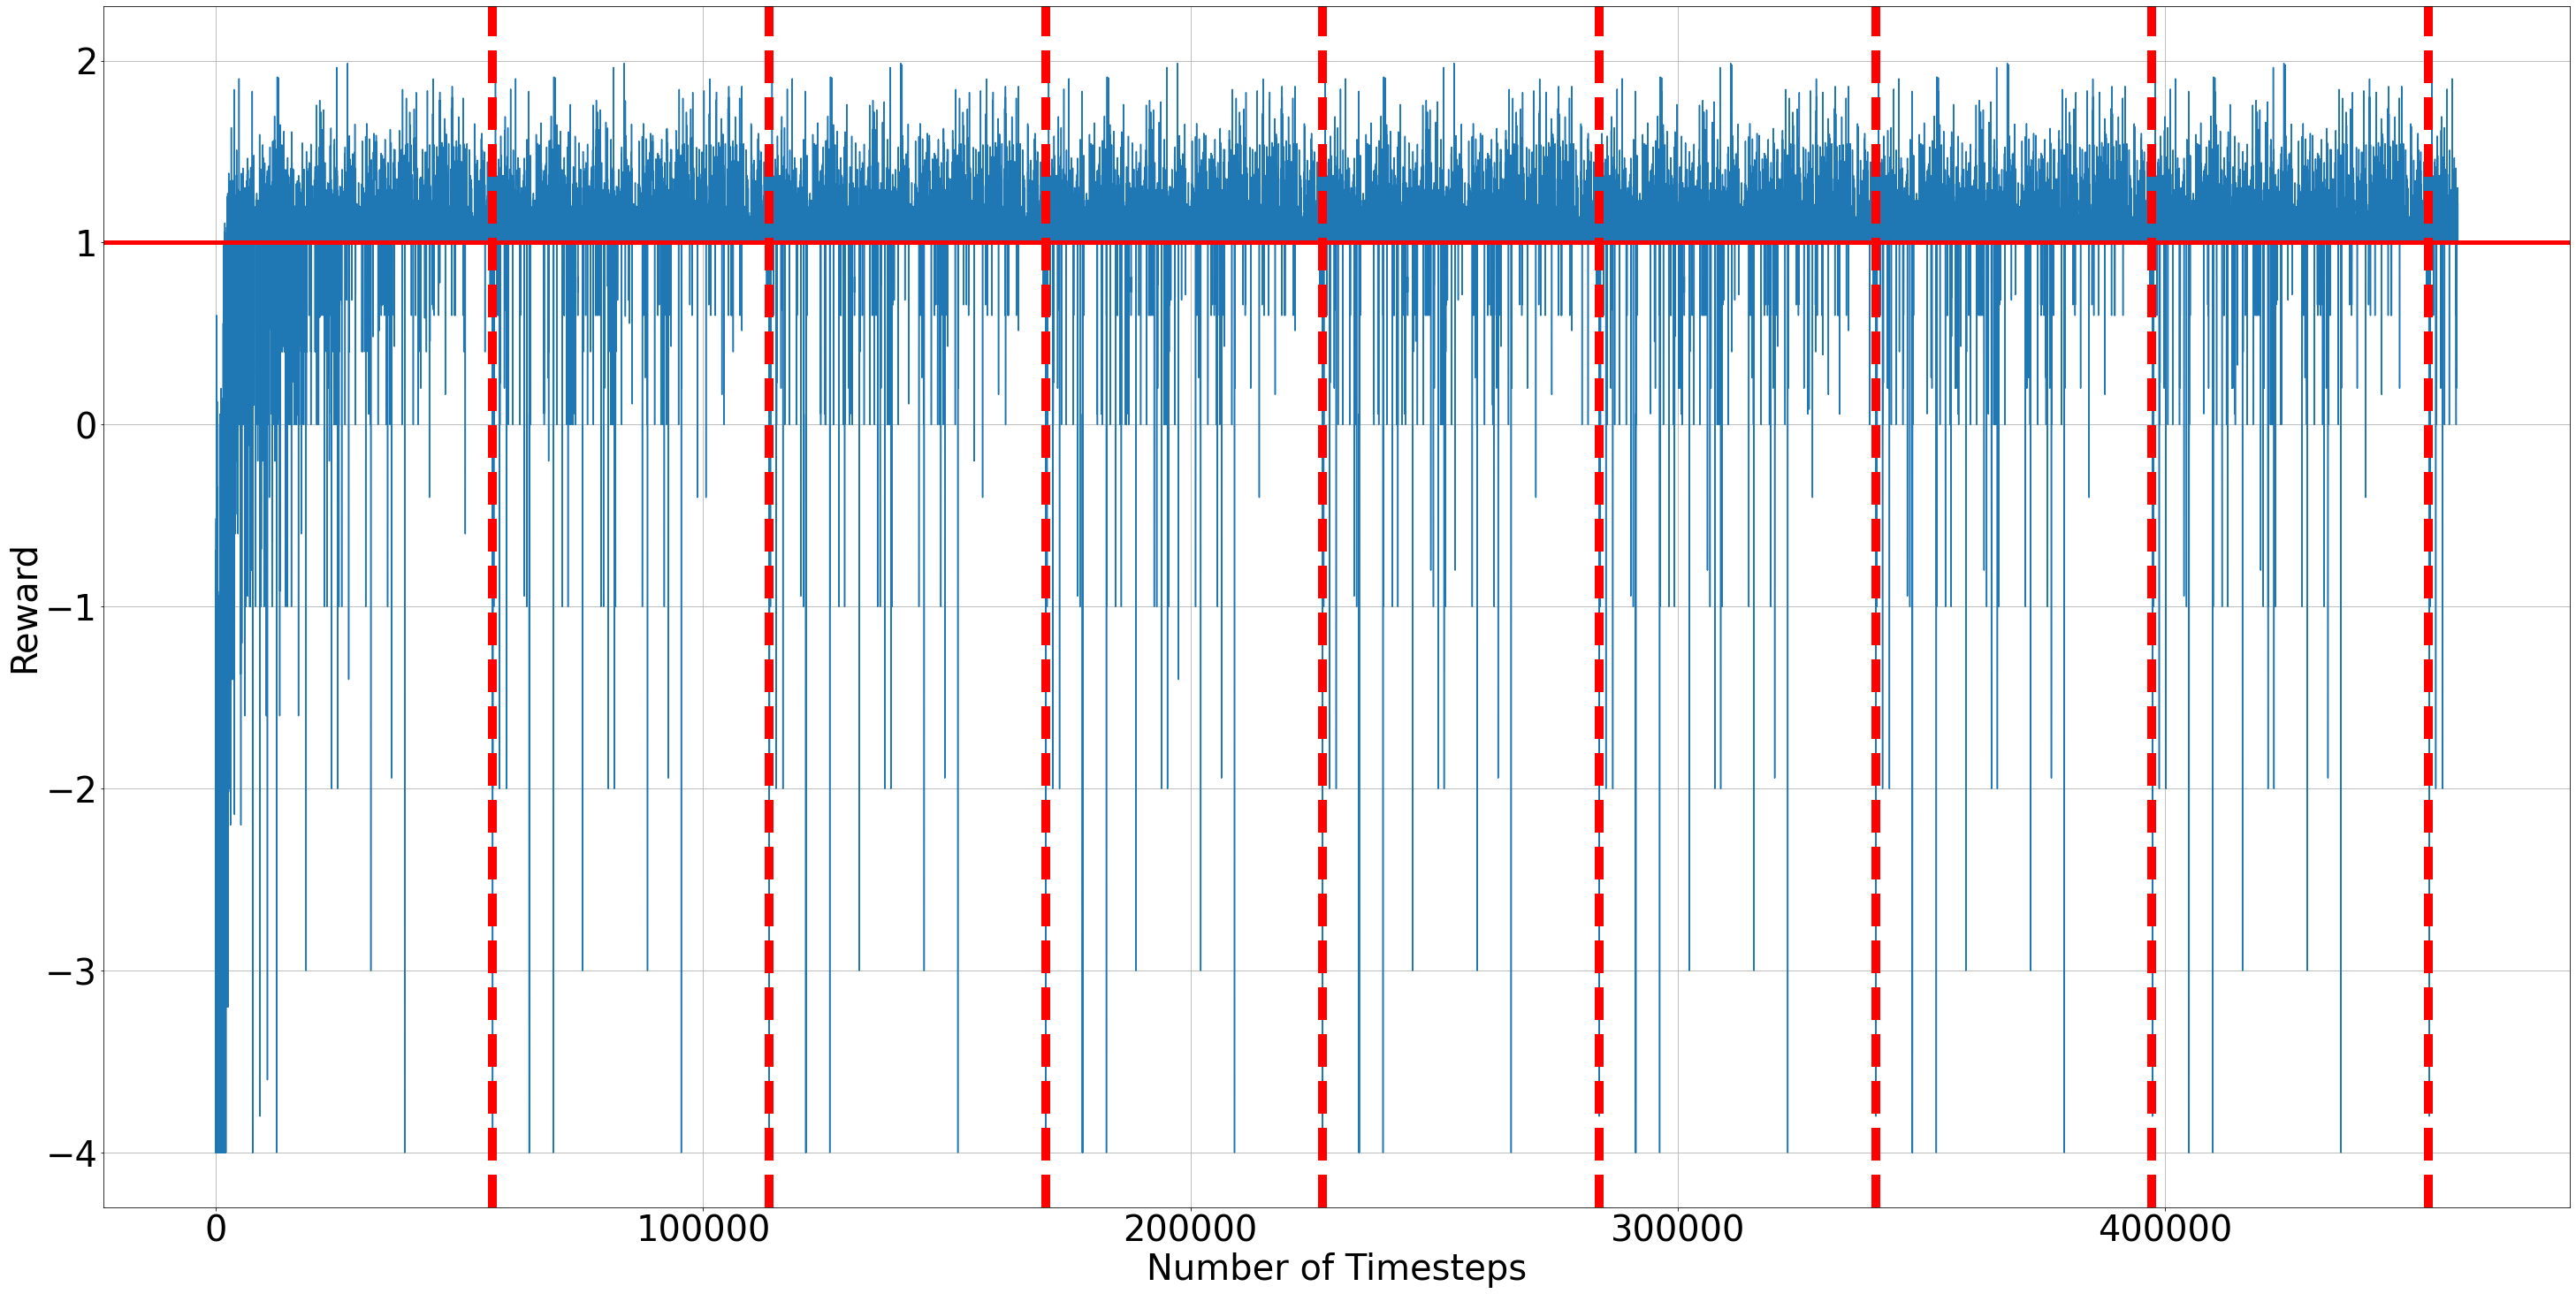

In [40]:
fig = plt.figure( figsize=(50, 25))
y = moving_average(PPO1_rewards_list, 5)
x = [i for i in range(0, len(y))]
plt.plot(x, y)
plt.xlabel('Number of Timesteps', fontsize=40)
plt.ylabel('Reward', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.title("DQN Learning Curve")

counter = 56755
while(counter<460000):
    plt.axvline(x=counter, color='red', linestyle='--', label='Episode', linewidth=10)
    counter = counter + 56755

plt.axhline(y=1, color='red', linestyle='-', label='Episode', linewidth=5)
plt.grid(True)
#plt.savefig("DQN_moving_average.pdf")
plt.show()

In [20]:
batch_size = 100
averages_list = []
for i in range(0, len(env.rewards_list), batch_size):
    # Extract a batch of numbers
    batch = env.rewards_list[i:i + batch_size]
    
    # Calculate the average of the batch and append it to the averages_list
    average = sum(batch) / len(batch)
    averages_list.append(average)

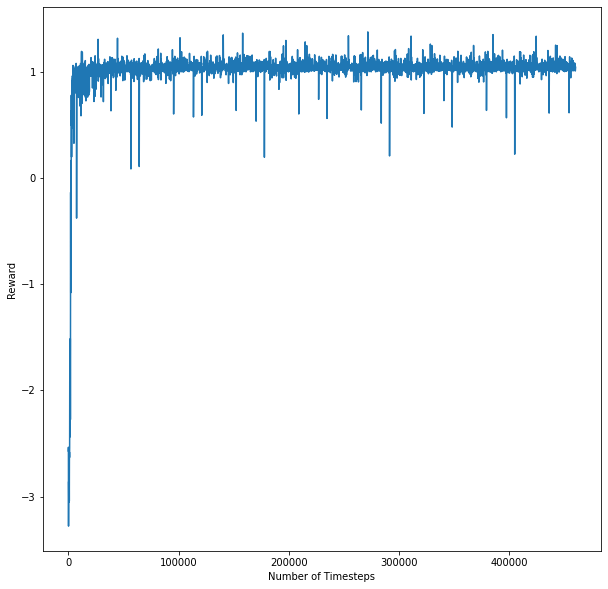

In [21]:
fig = plt.figure( figsize=(10, 10))
i = 0
x = [i*batch_size for i in range(0, len(averages_list))]
y = averages_list
plt.plot(x, y)
plt.xlabel('Number of Timesteps')
plt.ylabel('Reward')
#plt.title("Learning Curve")
plt.show()
#plt.savefig("fisrt step.pdf")

### PPO2

In [46]:
env.acc_zero()
start_time = time.time()
PPO2_model.learn(total_timesteps= 112000)
end_time = time.time()
print("DQN Execution Time: ", end_time - start_time)

DQN Execution Time:  264.80104756355286


In [47]:
batch_size = 250
averages_list = []
for i in range(0, len(env.rewards_list), batch_size):
    # Extract a batch of numbers
    batch = env.rewards_list[i:i + batch_size]
    
    # Calculate the average of the batch and append it to the averages_list
    average = sum(batch) / len(batch)
    averages_list.append(average)

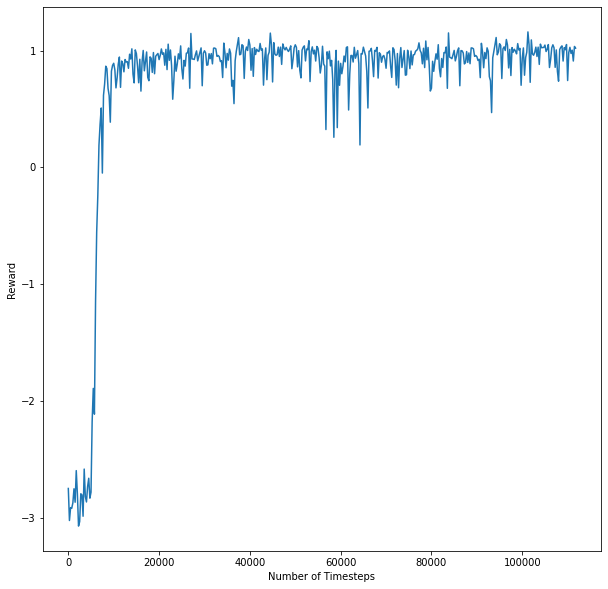

In [48]:
fig = plt.figure( figsize=(10, 10))
i = 0
x = [i*batch_size for i in range(0, len(averages_list))]
y = averages_list
plt.plot(x, y)
plt.xlabel('Number of Timesteps')
plt.ylabel('Reward')
#plt.title("Learning Curve")
plt.show()
#plt.savefig("fisrt step.pdf")

# Cross-project:

In [57]:
dataset_cross = pd.read_csv("/home/amirmahdi/projects/Adaptive-Logging-system-git/code/data/dataframe_main.csv")
dataset_cross = dataset_cross.set_index("ID")
dataset_cross = dataset_cross.astype(int)
env_cross = source_code_env(dataset_cross)
DQN_model.env = env_cross

In [43]:
dataset_cross

,number_of_loops,loop_input_dependent_level,nested_loop_level,number_of_defined_threads,number_of_started_threads,number_of_join_threads,number_of_defined_locks,number_of_acquired_locks_threads,number_of_released_locks,number_of_usage_of_extra,number_of_usage_of_values_list,number_of_usage_of_select_related
ID,,,,,,,,,,,,
5a723cc4bc73898ea681993d1ae70ba4a7a8aaa9,0,0,0,0,0,0,0,0,0,0,0,0
a33b567ba3afcfb275d43fca24a400c8bbd9ae8c,0,0,0,0,0,0,0,0,0,0,0,0
c1884969b3d1bcf7fd5dbf887f5d30c895a35a4d,0,0,0,0,0,0,0,0,0,0,0,0
7bcbe91ed1444729a2dc31f54682468aa79ed0b9,0,0,0,0,0,0,0,0,0,0,0,0
b33c59ca8af612089a8088c4f7737b5cf07d9d22,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
85e9d61bd19e9baa0a4791338518e52de24bcc4a,0,0,0,0,0,0,0,0,0,0,0,0
5729c34da0df5c51ac99f5d4e2a262ba5260e480,0,0,0,0,0,0,0,0,0,0,0,0
58d247bd03dbd87bef46672536baa39ee3e7063f,0,0,0,0,0,0,0,0,0,0,0,0


In [58]:
env_cross.acc_zero()
obs = env_cross.reset()
dones=0
while dones==0:
    action, _states = DQN_model.predict(obs)
    obs, rewards, dones, info = env_cross.step(action)
DQN_model.learn(total_timesteps= 150000)

In [60]:
env_cross.acc_zero()
for _ in range(0, 5):
    obs = env_cross.reset()
    dones=0
    while dones==0:
        action, _states = DQN_model.predict(obs)
        obs, rewards, dones, info = env_cross.step(action)
#PPO1_model.learn(total_timesteps= 150000)

In [46]:
A2C_rewards_list = env_cross.rewards_list   
len(A2C_rewards_list)

186729

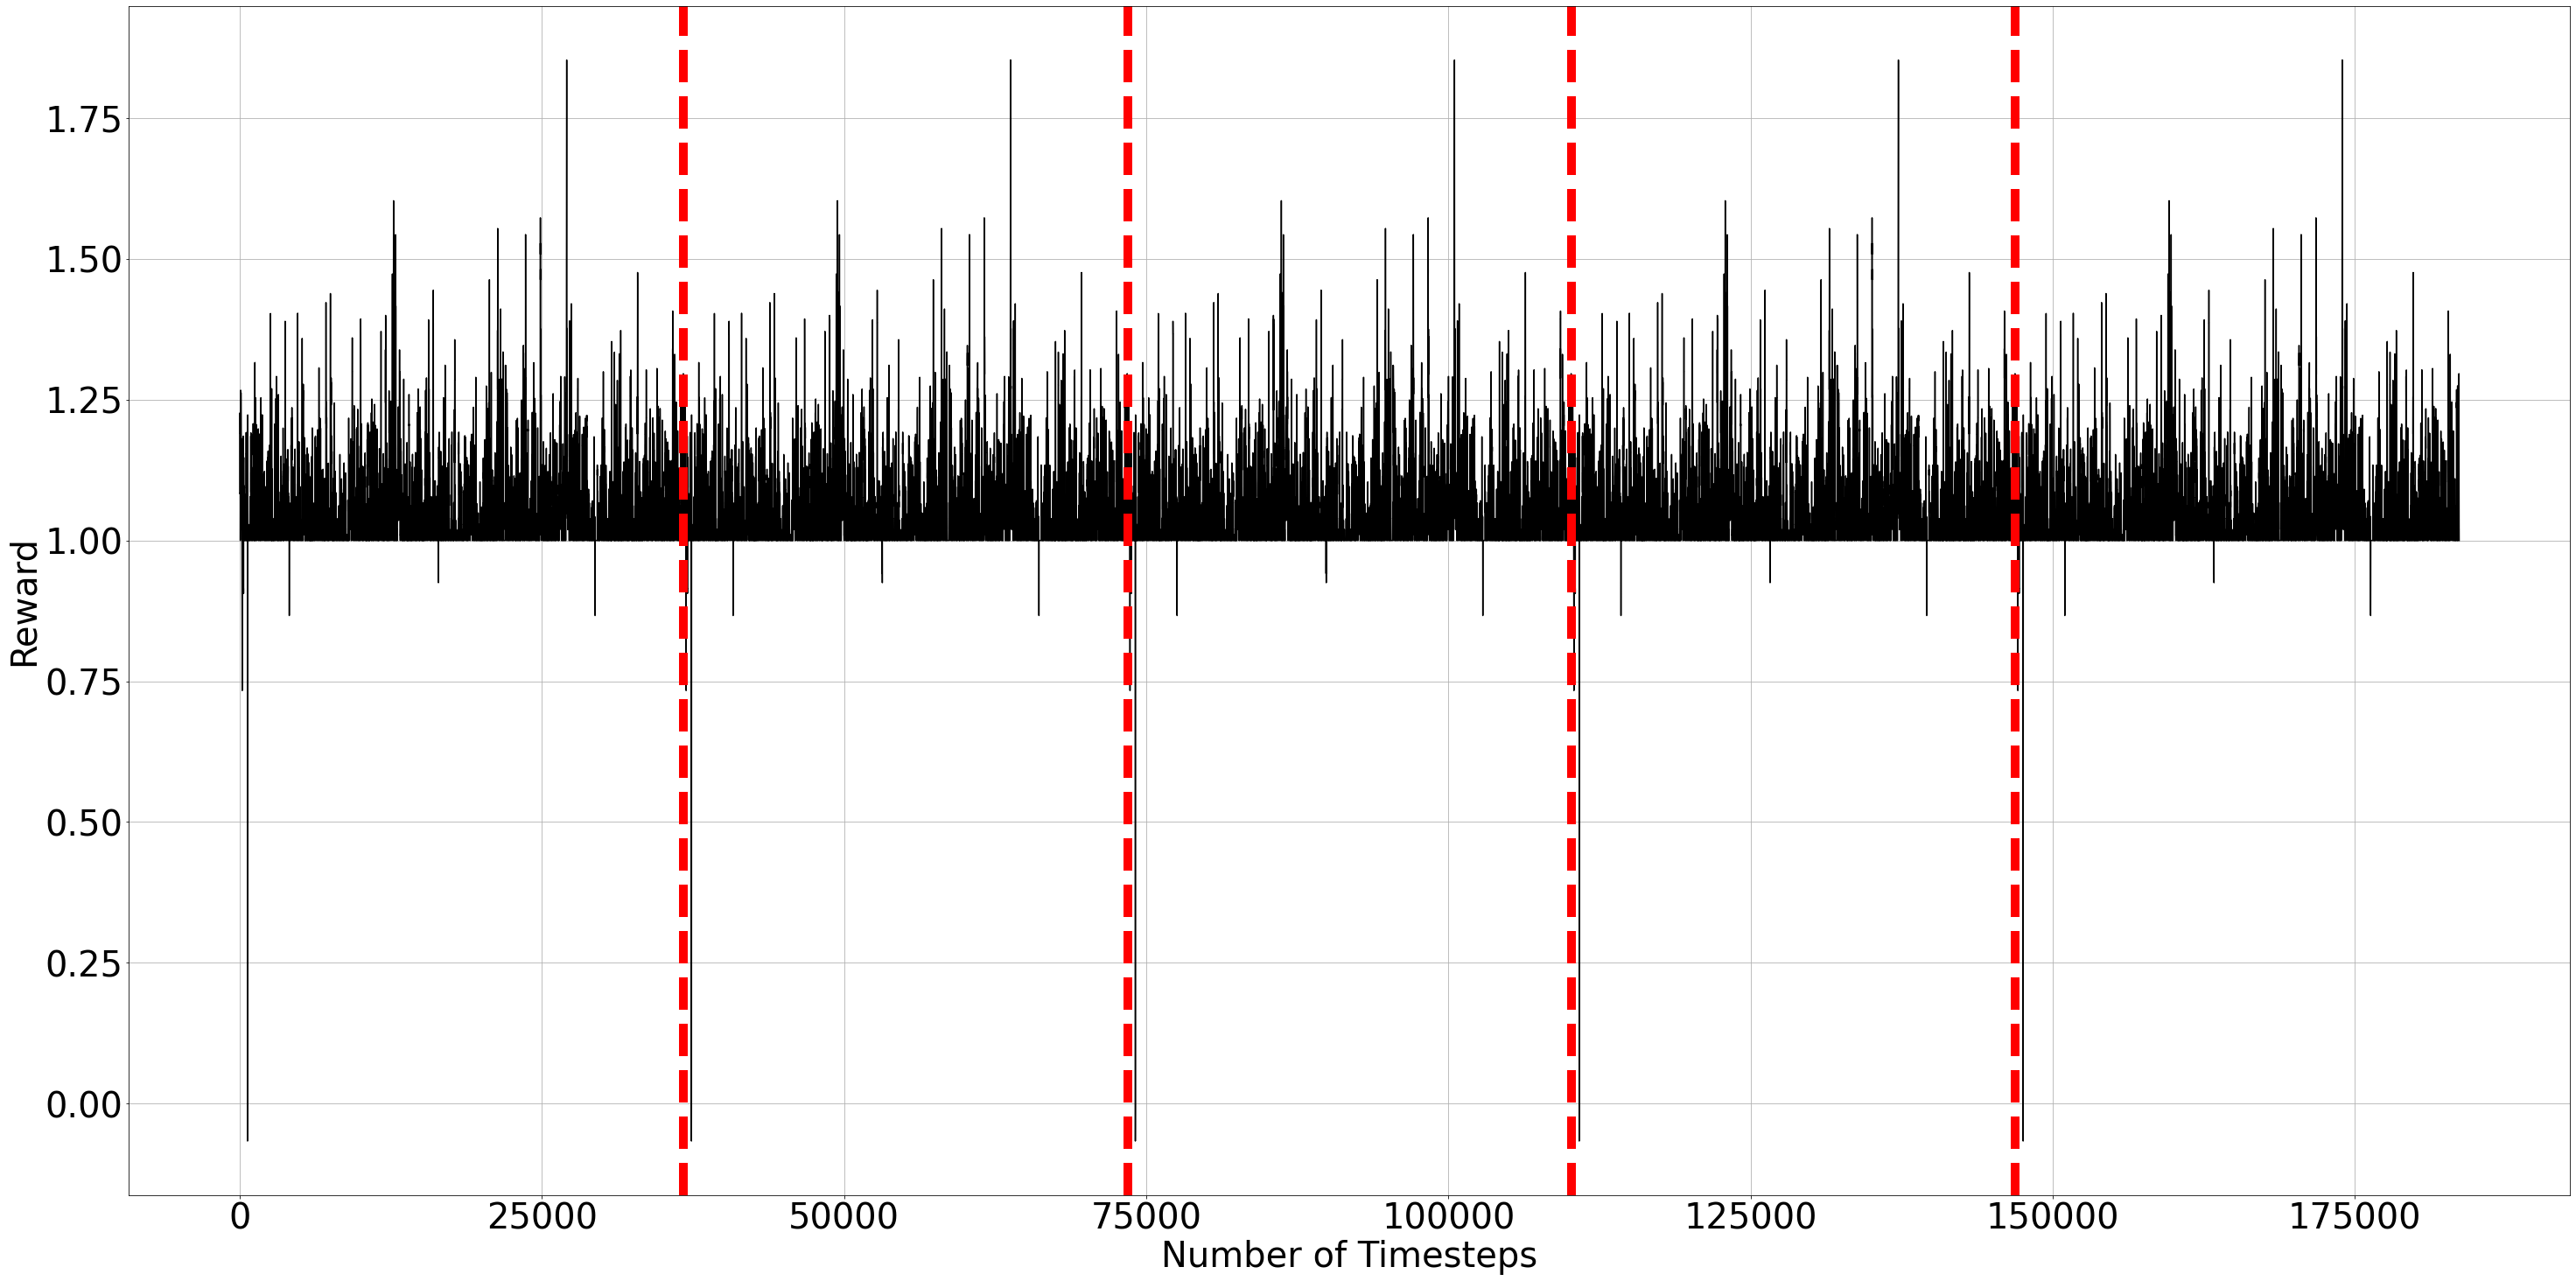

In [61]:
DQN_rewards_list = env_cross.rewards_list    
fig = plt.figure( figsize=(50, 25))
i = 0
y = moving_average(DQN_rewards_list, 15)
x = [i for i in range(0, len(y))]
plt.plot(x, y, color="black")
plt.xlabel('Number of Timesteps', fontsize=40)
plt.ylabel('Reward', fontsize=40)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
#plt.title("DQN Learning Curve")

counter = 36729
while(counter<150000):
    plt.axvline(x=counter, color='red', linestyle='--', label='Episode', linewidth=10)
    counter = counter + 36729

#plt.axhline(y=1, color='green', linestyle='-', label='Episode', linewidth=10)
#plt.axhline(y=0, color='red', linestyle='-', label='Episode', linewidth=10)
plt.grid(True)
plt.savefig("DQN_moving_average_cross.pdf")
plt.show()

# Future Work:

* Ading Function names
* Adding file names 
* TF-IDF
* Read/Write
* API MIsuses scenarios
* GP
* Trying different implementaton of reward function
    * Adding "NO_ACTION" as one of the actions
    * Mathematical implementation
    * Negative Reward
    * Normalization of the data
* Adding more source code
* Which Log level paper:

<img src="images/which-log-level-f.png" />

<img src="images/which-log-level-f1.png" />

* IDK 

# Garbage

In [3]:
def RLM_training(model, dataset, sample_freq):
    main_env = model.env
    iteration= math.floor(len(dataset) / sample_freq)
    
    accumulative_rewards = []
    for _ in range(10):
        start = 0
        end = sample_freq
        for i in range(iteration):
            print(f"************** ITERATION {i} ***************")
            train_env = source_code_env(dataset.iloc[start:end])
            start += sample_freq
            end += sample_freq
            model.env = train_env
            model.learn(total_timesteps= sample_freq)

            # Making predictions on test set 
            obs = main_env.reset()
            sum_rewards = 0
            dones=0
            while dones==0:
                action, _states = model.predict(obs)
                obs, rewards, dones, info = main_env.step(action)
                sum_rewards = sum_rewards + rewards

            print(sum_rewards)
            accumulative_rewards.append(sum_rewards)
            #model.setup_model()
    model.set_env(main_env)
    model.setup_model()
    return accumulative_rewards

In [ ]:
# Lists to store rewards for learning curve
episode_rewards = []

# Train the agent and collect rewards
total_timesteps = 1000
for _ in range(total_timesteps):
    model.learn(total_timesteps=env.spec.max_episode_steps)
    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=1)
    episode_rewards.append(mean_reward)

In [11]:
RLM_training(PPO1_model, dataset, 1000)

************** ITERATION 0 ***************
-2312.0668424364085
************** ITERATION 1 ***************
-976.9931641865121
************** ITERATION 2 ***************
259.37231097249463
************** ITERATION 3 ***************
577.5285441639663
************** ITERATION 4 ***************


KeyboardInterrupt: 

In [30]:
RLM_training(PPO1_model, dataset, 1000)

************** ITERATION 0 ***************
-105892.43333233181
************** ITERATION 1 ***************
-93366.86445800232
************** ITERATION 2 ***************
-52859.55859076892
************** ITERATION 3 ***************
-241.21294408099027
************** ITERATION 4 ***************
25041.244123070937
************** ITERATION 5 ***************
29334.184808858437
************** ITERATION 6 ***************
31816.80949102468
************** ITERATION 7 ***************
32761.255658405396
************** ITERATION 8 ***************
33243.951508952254
************** ITERATION 9 ***************
33352.36642821269
************** ITERATION 10 ***************
33456.03556007492
************** ITERATION 11 ***************
33533.11899358783
************** ITERATION 12 ***************
33548.38190711744
************** ITERATION 13 ***************
32820.339882977496
************** ITERATION 14 ***************
33368.39426957003
************** ITERATION 15 ***************
33745.44470004284
*******

KeyboardInterrupt: 

In [ ]:
    def step(self, action):
        done = False
        obs = self.dataset.iloc[self.t].astype(np.float32)
        reward = self._reward(obs, action)
        self.t += 1
        if self.t >= self.t_limit:
            done = True
            obs = self.reset()
        else:
            obs = self.dataset.iloc[self.t].astype(np.float32)
        info={}
        return np.array(obs), reward, done, info

In [ ]:
def step(self, action):
        
        done = True
        self.t += 1
        
        if self.t < self.t_limit:
            done = False
        
            obs = self.dataset.iloc[self.t - 1].astype(np.float32) # getting current observation to compute reward
            reward = self._reward(obs, action)
            next_obs = self.dataset.iloc[self.t].astype(np.float32) # getting updated observation after taken action
        
            info={}
        
            return np.array(obs), reward, done, info

In [ ]:
class LogEnvironment(gym.Env):
    metadata = {'render.modes': ['console']}
    
    
    def __init__(self,dataset, high = None, low = None):
        super(LogEnvironment, self).__init__()
        self.rewards = []
        self.dataset = dataset
        self.states = np.array(dataset.iloc[:,:-1])
        self.state = 0
        self.predict_classes = []
        
        n_actions = 4
        self.action_space = spaces.Discrete(n_actions)
        if high is None:
            low = np.array(dataset.iloc[:,:-1].min()).astype(np.float32)
            high = np.array(dataset.iloc[:,:-1].max()).astype(np.float32)
            self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        else:
            self.observation_space = spaces.Box(low=low, high=high, dtype=np.float32)
        
    
    def reset(self):
        self.state = 0
        LogEnvironment.predicts.append(self.predict_classes)
        self.predict_classes = []
        return self.states[self.state].astype(np.float32)
    
    def step(self, action):
        if action == self.NoLog:
            self.predict_classes.append(0)
        elif action == self.Log:
            self.predict_classes.append(1)
        else:
            raise ValueError("Received invalid action={} which is not part of the action space".format(action))
        
        done = bool(self.state >= len(self.classes)-1)
        
        
        
        reward = 1 if self.predict_classes[self.state] == self.classes[self.state] else 0
        self.rewards.append(reward)
        
        self.state += 0 if done else 1
        
        info = {}
        
        return self.states[self.state].astype(np.float32), reward, done, info
        

In [37]:
class test:
    d = []
    p = 1
    def __init__(self, dataset):
        self.dataset = dataset.copy()
        test.d.append(p)
        
    def fun(self):
        self.dataset.append("a")

In [38]:
lst = ["Amir"]
cls = test(lst)

NameError: name 'p' is not defined

In [36]:
lst

['Amir']

In [35]:
cls.dataset

['Amir', 'a']

In [33]:
cls.d

['b']

In [6]:
features_for_reward_func = {
        "number_of_loops": 0,
        "nesting_level": 1,
        "input_dependant_level": 2,
        "number_of_defined_threads": 3,
        "number_of_started_threads": 4,
        "number_of_join_threads": 5,
        "number_of_defined_locks": 6,
        "number_of_acquired_locks_threads": 7,
        "number_of_released_locks": 8,
        "number_of_usage_of_extra": 9,
        "number_of_usage_of_values_list": 10,
        "number_of_usage_of_select_related": 11
    }
features_for_reward_func["number_of_loops"]

0

In [3]:
a = 1 > 0
print(a)

True


In [7]:
def _sigmoid(x_coefficient, x):
        
        """
        arguments:
        
        x_coefficient: this is to control the slope of the Sigmoid function.
        x: input of the Sigmoid function.
        """
            
        x = x_coefficient * x
        return ((1/(1 + np.exp(-x))) - 0.5) * 2
    
_sigmoid(0.35, 6)

0.7818063576087741

In [24]:
def _action_determiner(obs):
        """
        The implementation logic of assiging each performance bug to a certain log level
        is based on the knowledge from previous studies mentioned above, the how common and important they are and
        also our features capabalities.
        
        arguments:
        
        obs: is supposed to be a vector (a row of the pandas dataframe);
        
        """
        synchronization_features = obs[features_for_reward_func["number_of_defined_threads"]:
            features_for_reward_func["number_of_usage_of_extra"]]
        api_related_features = obs[features_for_reward_func["number_of_usage_of_extra"]:]
        determined_action = actions["IDK"] # Default action
        
        if (obs == 0).all(): # Checking if any of features has occured
            determined_action = actions["NOT_LOG"]
            return determined_action
        elif (synchronization_features > 0).any():
            determined_action = actions["TRACE"]
            
            obs_num_threads = obs[features_for_reward_func["number_of_defined_threads"]]
            obs_num_locks = obs[features_for_reward_func["number_of_defined_locks"]]
            obs_num_join = obs[features_for_reward_func["number_of_join_threads"]]
            race_condition_metric = obs_num_threads - obs_num_locks
            deadlock_metric = obs_num_threads - obs_num_join
            if race_condition_metric > 0 or deadlock_metric > 0: 
                determined_action = actions["DEBUG"]
            return determined_action
        else:
            nested_loop = obs[features_for_reward_func["nesting_level"]] > 0
            input_dependant = obs[features_for_reward_func["input_dependant_level"]] > 0
            if nested_loop or input_dependant:
                determined_action = actions["INFO"]
                return determined_action
            elif (api_related_features != 0).any():
                determined_action = actions["WARN"]
                return determined_action
            else:
                determined_action = 5
        return determined_action

In [14]:
actions = {
    "NOT_LOG": 0,
    "TRACE": 1,
    "DEBUG": 2,
    "INFO": 3,
    "WARN": 4,
    "IDK": 5
}

features_for_reward_func = {
    "number_of_loops": 0,
    "nesting_level": 1,
    "input_dependant_level": 2,
    "number_of_defined_threads": 3,
    "number_of_started_threads": 4,
    "number_of_join_threads": 5,
    "number_of_defined_locks": 6,
    "number_of_acquired_locks_threads": 7,
    "number_of_released_locks": 8,
    "number_of_usage_of_extra": 9,
    "number_of_usage_of_values_list": 10,
    "number_of_usage_of_select_related": 11
}
df = pd.read_csv("data/dataframe.csv").set_index("ID")


number_of_loops                      0.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage_of_values_list       0.0
number_of_usage_of_select_related    0.0
Name: ee2c971f20132061d7e749267b166730ff734a7c, dtype: float32


In [25]:
for i in range(len(df)):
    obs = df.iloc[i].astype(np.float32)
    
    if _action_determiner(obs) != 0:
        print(obs)
        print("ACTION: ", _action_determiner(obs))
        print("------------------------------------------")

number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage_of_values_list       0.0
number_of_usage_of_select_related    0.0
Name: dd15cd5b22997fef1b6efa5ffa71d6ce84de30c5, dtype: float32
ACTION:  5
------------------------------------------
number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_ext

ACTION:  5
------------------------------------------
number_of_loops                      1.0
nested_loop_level                    2.0
loop_input_dependent_level           2.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage_of_values_list       0.0
number_of_usage_of_select_related    0.0
Name: 0a25ba5991316bdda4a9b3abcee2106016df28a0, dtype: float32
ACTION:  3
------------------------------------------
number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of

ACTION:  3
------------------------------------------
number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage_of_values_list       0.0
number_of_usage_of_select_related    0.0
Name: 97418507bc2fc7d55435bc3ca888b6b73c00df6e, dtype: float32
ACTION:  5
------------------------------------------
number_of_loops                      2.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of

ACTION:  3
------------------------------------------
number_of_loops                      2.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage_of_values_list       0.0
number_of_usage_of_select_related    0.0
Name: 1925f793093581c47a5c6b2e414506b1cbae280d, dtype: float32
ACTION:  5
------------------------------------------
number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of

In [26]:
for i in range(len(df)):
    print(df.iloc[i] if (df.iloc[i] != 0).any() else "-------------------")

-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage_of_values_list       0.0
number_of_usage_of_select_related    0.0
Name: dd15cd5b22997fef1b6efa5ffa71d6ce84de30c5, dtype: float64
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
-------------------
number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
nu

-------------------
-------------------
number_of_loops                      2.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage_of_values_list       0.0
number_of_usage_of_select_related    0.0
Name: e540cdd1328b2b21e29a95405c301b9313b7c346, dtype: float64
number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra            

number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage_of_values_list       0.0
number_of_usage_of_select_related    0.0
Name: 1925f793093581c47a5c6b2e414506b1cbae280d, dtype: float64
-------------------
number_of_loops                      1.0
nested_loop_level                    0.0
loop_input_dependent_level           0.0
number_of_defined_threads            0.0
number_of_started_threads            0.0
number_of_join_threads               0.0
number_of_defined_locks              0.0
number_of_acquired_locks_threads     0.0
number_of_released_locks             0.0
number_of_usage_of_extra             0.0
number_of_usage